In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

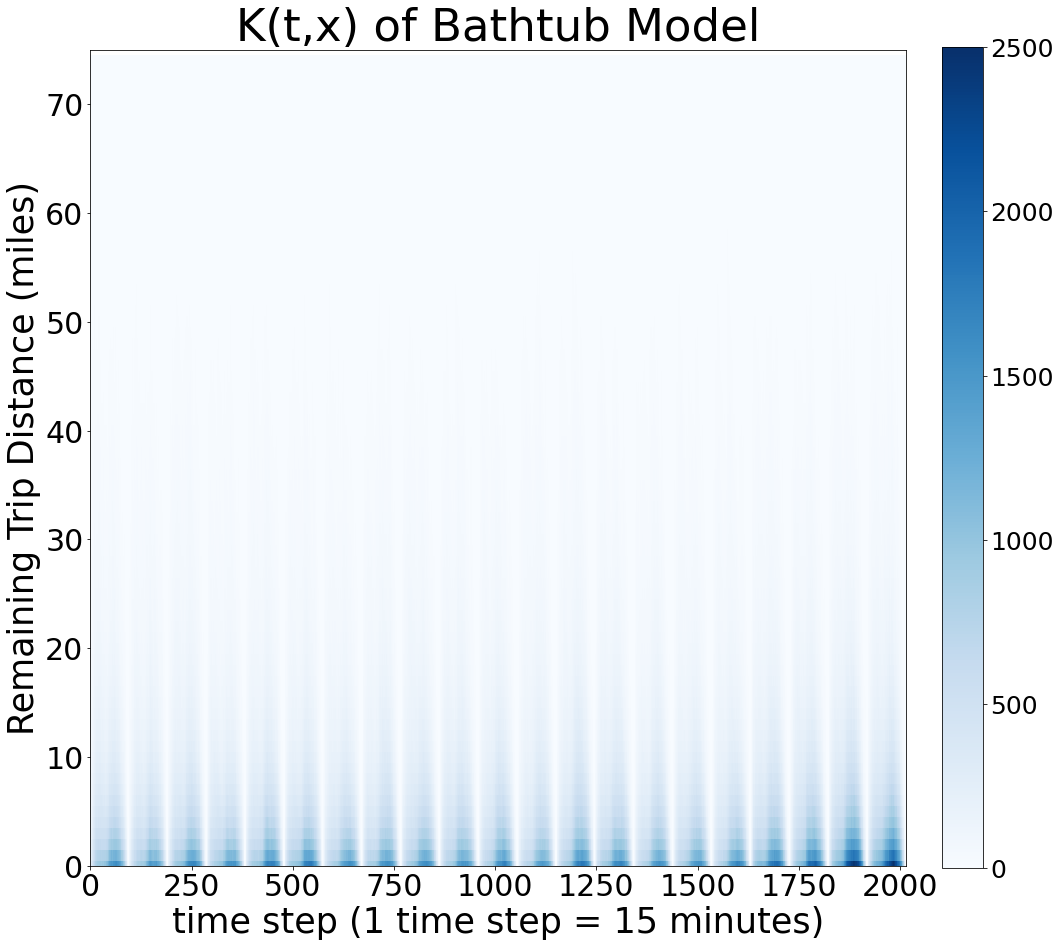

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.94594595, 0.37121588],
       [0.54054054, 0.4133995 ],
       [0.        , 0.27940447],
       ...,
       [0.33783784, 0.43920596],
       [0.94594595, 0.47096774],
       [0.40540541, 0.91414392]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.012026699641273371 0.012026699641273371 0.8478221918148617
0.011360422052450693 0.011360422052450693 0.8238643094627734
0.0095991388248953414 0.0095991388248953414 0.7556813293746599
0.0093779838601528286 0.0093779838601528286 0.7467467880876415
0.0093731579369297265 0.0093731579369297265 0.7464615769693894
0.0093692760035722564 0.0093692760035722564 0.7462733827198752
0.00935779895982193 0.00935779895982193 0.7458024921926943
0.0093414310151426587 0.0093414310151426587 0.7452066919550494
0.0093036453547975517 0.0093036453547975517 0.743821985341012
0.0092536613041844865 0.0092536613041844865 0.7419885337108628
0.0091929854207081843 0.0091929854207081843 0.7396590672100989
0.00902750322442313 0.00902750322442313 0.7330696876843882
0.0087618306776242171 0.0087618306776242171 0.7225281038123111
0.0083946676358670168 0.0083946676358670168 0.7077974206557013
0.0082507801076315435 0.0082507801076315435 0.7018294685024953
0.0079062972061120264 0.0079062972061120264 0.6876562076570135
0.007

0.0032894994228892145 0.0032894994228892145 0.4283223067522895
0.0032894256070739453 0.0032894256070739453 0.4282975327395977
0.0032893248685844628 0.0032893248685844628 0.42829905018744224
0.0032890767888512952 0.0032890767888512952 0.42821109514798966
0.003288543716066909 0.003288543716066909 0.42807227190247493
0.0032878976726072968 0.0032878976726072968 0.4280228417097802
0.003286858319771704 0.003286858319771704 0.4282770534947417
0.0032863340097532218 0.0032863340097532218 0.42806463111718074
0.0032861427355638339 0.0032861427355638339 0.4279510458213251
0.0032859951320109086 0.0032859951320109086 0.4279109575516056
0.0032858397038209534 0.0032858397038209534 0.42798823431702077
0.0032857423692487136 0.0032857423692487136 0.4280032490102695
0.0032856978634952464 0.0032856978634952464 0.42802934820306465
0.0032856606479963182 0.0032856606479963182 0.4280395976581316
0.0032856238329386374 0.0032856238329386374 0.42802728751237484
0.0032855566872215082 0.0032855566872215082 0.428017

0.0032023926387976147 0.0032023926387976147 0.42501049998260254
0.0032023544165452459 0.0032023544165452459 0.42498106111013395
0.0032023464234932019 0.0032023464234932019 0.42499798581304965
0.0032022526136923288 0.0032022526136923288 0.4250256644759059
0.0032022364461370616 0.0032022364461370616 0.4250120874586311
0.0032022036207060059 0.0032022036207060059 0.42501342216282023
0.0032021642313253573 0.0032021642313253573 0.4250318655493739
0.003202148386611378 0.003202148386611378 0.4250532611811572
0.0032021393592661773 0.0032021393592661773 0.42507699469240656
0.0032021303834476869 0.0032021303834476869 0.42507090608428705
0.0032021251563079593 0.0032021251563079593 0.4250733186894239
0.0032021184090869938 0.0032021184090869938 0.42505674536565746
0.0032021062465530403 0.0032021062465530403 0.42504869330709977
0.0032020889157038392 0.0032020889157038392 0.42504875317751867
0.0032020635913892477 0.0032020635913892477 0.4250589551780294
0.0032020489992660977 0.0032020489992660977 0.42

0.0031951198253574883 0.0031951198253574883 0.42651365843229083
0.0031950959723486094 0.0031950959723486094 0.42687606199015965
0.0031948893428279087 0.0031948893428279087 0.4268535590528786
0.0031947164406625188 0.0031947164406625188 0.4267061515402633
0.0031946553110464159 0.0031946553110464159 0.4266122312038557
0.0031945153985829086 0.0031945153985829086 0.42653272861874214
0.0031941407874533072 0.0031941407874533072 0.4265200285474396
0.003193850521222489 0.003193850521222489 0.42660435858196327
0.0031929632515094392 0.0031929632515094392 0.42683909320467683
0.0031922297864201551 0.0031922297864201551 0.4271603350800109
0.0031916820775468534 0.0031916820775468534 0.42731104209748766
0.0031908723299700738 0.0031908723299700738 0.4275647810814636
0.0031899468659845188 0.0031899468659845188 0.4279390222532509
0.0031891541088942257 0.0031891541088942257 0.42810232979448815
0.0031877794824358183 0.0031877794824358183 0.4283709375025974
0.0031873143413194351 0.0031873143413194351 0.4283

0.0031582644600249075 0.0031582644600249075 0.43432008303214303
0.0031577111987855368 0.0031577111987855368 0.43472152848623763
0.0031575144749271646 0.0031575144749271646 0.43487664304454376
0.0031571131097462924 0.0031571131097462924 0.4351548508246305
0.0031568127394782245 0.0031568127394782245 0.435155340789225
0.0031566421015995624 0.0031566421015995624 0.4349138095579733
0.0031565770360447716 0.0031565770360447716 0.4346302084881687
0.0031564374737640712 0.0031564374737640712 0.43466659864693763
0.0031563432021088963 0.0031563432021088963 0.4349020294894951
0.0031562479654423823 0.0031562479654423823 0.4349583534180713
0.0031561660352258411 0.0031561660352258411 0.43493794452359547
0.0031560173890771343 0.0031560173890771343 0.43480064147335673
0.0031558997855747361 0.0031558997855747361 0.43480875354580123
0.0031558306972793338 0.0031558306972793338 0.43469810271737636
0.0031557478340543442 0.0031557478340543442 0.43464573846451204
0.0031556958817116712 0.0031556958817116712 0.4

0.0031450658929901508 0.0031450658929901508 0.43494941497322914
0.0031449920901618304 0.0031449920901618304 0.43483952525849495
0.0031449727670925603 0.0031449727670925603 0.4348561379418994
0.0031449509058432469 0.0031449509058432469 0.43487210036588314
0.0031449039394052542 0.0031449039394052542 0.43491692777825597
0.0031447756849118554 0.0031447756849118554 0.434883101549348
0.0031446628941205952 0.0031446628941205952 0.43478955776856654
0.0031444505158851319 0.0031444505158851319 0.43463697464998935
0.0031443269984857045 0.0031443269984857045 0.4344187535709354
0.0031442949616024289 0.0031442949616024289 0.43418497182526167
0.0031442782032548933 0.0031442782032548933 0.43421472806029765
0.0031442380249179468 0.0031442380249179468 0.43433069252149276
0.0031441967716918521 0.0031441967716918521 0.4344097004851369
0.0031441653553260624 0.0031441653553260624 0.43440524924401214
0.003144099688264226 0.003144099688264226 0.4343401531758646
0.0031440288735322388 0.0031440288735322388 0.43

0.0029651372926412381 0.0029651372926412381 0.4130648667497847
0.002964274530703811 0.002964274530703811 0.41273498403898823
0.0029634488227566176 0.0029634488227566176 0.4123901001386127
0.0029613144941390535 0.0029613144941390535 0.41151136270320604
0.0029574335069718627 0.0029574335069718627 0.41143677926610084
0.00295429041783207 0.00295429041783207 0.41199379463760155
0.0029505037000970478 0.0029505037000970478 0.41256114096184665
0.0029492951764849957 0.0029492951764849957 0.41266540225124354
0.0029480761506602716 0.0029480761506602716 0.4128907833227664
0.0029473375541369724 0.0029473375541369724 0.412896832218017
0.0029459228365025189 0.0029459228365025189 0.41259506527585443
0.0029443521035040043 0.0029443521035040043 0.412466322255935
0.0029423483604027008 0.0029423483604027008 0.41241044333554805
0.0029406546886972624 0.0029406546886972624 0.41210437903887054
0.0029376387834726832 0.0029376387834726832 0.41163932067059333
0.0029359070156461282 0.0029359070156461282 0.4114355

0.0026959793351576996 0.0026959793351576996 0.38614129686056936
0.0026937810332326789 0.0026937810332326789 0.3861035312338878
0.0026902096717937485 0.0026902096717937485 0.38634437362163354
0.0026872273948031237 0.0026872273948031237 0.3863331195582044
0.0026851730294847305 0.0026851730294847305 0.38619631244544295
0.00268112135488564 0.00268112135488564 0.38629380927065016
0.0026785464897171392 0.0026785464897171392 0.38595104734866575
0.0026777869904837043 0.0026777869904837043 0.38565522217917314
0.0026766452572279361 0.0026766452572279361 0.38576882664813517
0.0026753380591132384 0.0026753380591132384 0.3858827034714619
0.0026727057431395929 0.0026727057431395929 0.3858200099584035
0.002670477022446396 0.002670477022446396 0.3862492762470996
0.002668310136656095 0.002668310136656095 0.385685311187131
0.0026668851627015271 0.0026668851627015271 0.38542921637005306
0.0026661965190580561 0.0026661965190580561 0.38555648227654427
0.002662752036327278 0.002662752036327278 0.38535070155

0.00245006678721348 0.00245006678721348 0.3732592690815896
0.0024493327096883383 0.0024493327096883383 0.37331429590963533
0.0024477611836531414 0.0024477611836531414 0.37324219362523336
0.0024458387592352551 0.0024458387592352551 0.3736854709218558
0.0024448822618330971 0.0024448822618330971 0.37447042138264963
0.0024440530113048462 0.0024440530113048462 0.374914372209376
0.0024436932239484768 0.0024436932239484768 0.37444070584885103
0.002443297284830503 0.002443297284830503 0.3745004256941948
0.0024428421915050477 0.0024428421915050477 0.3748705043120095
0.0024424735633808759 0.0024424735633808759 0.3749389437870116
0.0024420188325391069 0.0024420188325391069 0.37472869966218453
0.0024411470036003941 0.0024411470036003941 0.3741357467408017
0.0024404385971400983 0.0024404385971400983 0.3737465741923108
0.0024393722496839189 0.0024393722496839189 0.3733099727504513
0.0024378208882830771 0.0024378208882830771 0.3729971143984674
0.0024358877401189903 0.0024358877401189903 0.37287832142

0.0023108786299535495 0.0023108786299535495 0.3669360087995331
0.0023097250674906722 0.0023097250674906722 0.3663518035451671
0.0023094218312247378 0.0023094218312247378 0.36626058636599174
0.0023085551607840687 0.0023085551607840687 0.36623503570986626
0.0023083388673211095 0.0023083388673211095 0.3661913110221737
0.0023069967116357035 0.0023069967116357035 0.3660780483957874
0.0023061641374301682 0.0023061641374301682 0.36602002079541157
0.0023048310901195037 0.0023048310901195037 0.36608785674057875
0.0023035380446460793 0.0023035380446460793 0.3657449594478074
0.0023020691261882646 0.0023020691261882646 0.36619744278674016
0.002301118409181996 0.002301118409181996 0.3660697283175359
0.0023007574334468106 0.0023007574334468106 0.3658034227335308
0.0022988853332799484 0.0022988853332799484 0.3660341441246064
0.002297863271948935 0.002297863271948935 0.36604718562917526
0.00229655838646315 0.00229655838646315 0.365890197042065
0.0022936215458429195 0.0022936215458429195 0.365744131139

0.0021704185461882326 0.0021704185461882326 0.3591200617952315
0.0021702916018902507 0.0021702916018902507 0.3590876361158732
0.0021701040983530318 0.0021701040983530318 0.35897334739414993
0.0021698808458810487 0.0021698808458810487 0.35882564070428613
0.0021696089616631609 0.0021696089616631609 0.35860124091081796
0.0021694351811786645 0.0021694351811786645 0.35848328641675964
0.0021691449226267177 0.0021691449226267177 0.3583925409311077
0.0021689993562160029 0.0021689993562160029 0.3583764085359613
0.002168823349729843 0.002168823349729843 0.3583424073166373
0.0021686065569349266 0.0021686065569349266 0.3582869183400888
0.002168473791864359 0.002168473791864359 0.3583959766093137
0.0021680393907277337 0.0021680393907277337 0.3583549304691389
0.0021673808890981228 0.0021673808890981228 0.3585135037419624
0.00216705474326557 0.00216705474326557 0.35886002217361906
0.0021665581670162809 0.0021665581670162809 0.35902333671202846
0.0021661875289012895 0.0021661875289012895 0.35908320272

0.0021210785136676086 0.0021210785136676086 0.35441202272947103
0.00212088450378051 0.00212088450378051 0.3550568277910333
0.0021205508488038507 0.0021205508488038507 0.35466048576843845
0.0021204809004394696 0.0021204809004394696 0.35437196035361296
0.0021198190318991407 0.0021198190318991407 0.35486360216840923
0.002119515037487509 0.002119515037487509 0.3560804031151484
0.0021190650230079743 0.0021190650230079743 0.35677250422814777
0.0021186305305334772 0.0021186305305334772 0.3589426701270678
0.0021185748607658065 0.0021185748607658065 0.3574869145637183
0.0021183494810514897 0.0021183494810514897 0.3589985222692387
0.0021182462468145049 0.0021182462468145049 0.35870590980394773
0.0021181171412804605 0.0021181171412804605 0.3588688536008619
0.0021180010703721794 0.0021180010703721794 0.3589079037898644
0.0021179061540479113 0.0021179061540479113 0.3583919870211223
0.0021178196238682933 0.0021178196238682933 0.35846305259529887
0.0021176512046542505 0.0021176512046542505 0.35874728

0.0020832266098246774 0.0020832266098246774 0.39862859768750386
0.0020830454535654217 0.0020830454535654217 0.4000174008100863
0.002082604244795339 0.002082604244795339 0.40304627361817835
0.0020822056302779103 0.0020822056302779103 0.403878355345432
0.0020815069804030451 0.0020815069804030451 0.4065267044005487
0.00208049489666852 0.00208049489666852 0.40619508896868933
0.002079236900041683 0.002079236900041683 0.4082494281507526
0.0020784241314425827 0.0020784241314425827 0.41108799526445655
0.002077693705968366 0.002077693705968366 0.4117737001209062
0.0020764572378076766 0.0020764572378076766 0.41335571680464256
0.0020758900961944339 0.0020758900961944339 0.41603654087765773
0.002075006313067158 0.002075006313067158 0.41999681871986766
0.00207441034183953 0.00207441034183953 0.4194998794072019
0.0020735305540299283 0.0020735305540299283 0.4201973802444094
0.002073162227553633 0.002073162227553633 0.4191360750545872
0.0020724915574978566 0.0020724915574978566 0.4208621124742964
0.00

0.0019345582342369389 0.0019345582342369389 0.3419912297263977
0.001933497648263213 0.001933497648263213 0.3415537005517714
0.0019326965110554898 0.0019326965110554898 0.3415875921550183
0.0019309361470620796 0.0019309361470620796 0.3415757781806391
0.001930393475252155 0.001930393475252155 0.34160156269069886
0.0019301180830630269 0.0019301180830630269 0.34138319991120486
0.0019297391509136433 0.0019297391509136433 0.34139802541231856
0.0019295818198485333 0.0019295818198485333 0.341375514294998
0.0019293031132173539 0.0019293031132173539 0.34126353803246995
0.001929027800618025 0.001929027800618025 0.34113871713255584
0.001928756871660496 0.001928756871660496 0.3408976645423462
0.001928512643037778 0.001928512643037778 0.3409238485448731
0.0019283125092831946 0.0019283125092831946 0.34087048632932243
0.001928111255533138 0.001928111255533138 0.3408582522635969
0.0019276827391796921 0.0019276827391796921 0.34079952757608456
0.00192704759936937 0.00192704759936937 0.34080864217438034
0

0.0018628130218219761 0.0018628130218219761 0.3344038154394216
0.0018626158814391551 0.0018626158814391551 0.33426096140023803
0.0018625197771722677 0.0018625197771722677 0.33436809272326146
0.0018622676515466182 0.0018622676515466182 0.3339304617962048
0.0018619018309257997 0.0018619018309257997 0.33350634001098894
0.00186170617380907 0.00186170617380907 0.33329587530951965
0.0018613960392183115 0.0018613960392183115 0.3332258061744316
0.0018609210839584044 0.0018609210839584044 0.33319946618865437
0.0018604181463796449 0.0018604181463796449 0.33321036083344824
0.0018599581068616854 0.0018599581068616854 0.3332349086066011
0.0018595213802458494 0.0018595213802458494 0.33323316293475913
0.0018590514259549623 0.0018590514259549623 0.33328853941339615
0.0018585245614018287 0.0018585245614018287 0.33333129665292377
0.0018581615713877055 0.0018581615713877055 0.33334332167408715
0.0018579120620920684 0.0018579120620920684 0.33343286649088216
0.0018578510555507196 0.0018578510555507196 0.33

0.0018145466541076858 0.0018145466541076858 0.3310235469597461
0.0018142951196153869 0.0018142951196153869 0.33097020107156927
0.0018140202048953342 0.0018140202048953342 0.3310890872978453
0.001813750447314197 0.001813750447314197 0.33118203797751006
0.0018135487445879116 0.0018135487445879116 0.3312038558966929
0.0018133945848685042 0.0018133945848685042 0.3311197833599622
0.001813258591444116 0.001813258591444116 0.331028785962999
0.0018131284449653493 0.0018131284449653493 0.33093635213780703
0.0018129943147460381 0.0018129943147460381 0.33081678543210835
0.0018129658642227621 0.0018129658642227621 0.33077044793228483
0.0018127787436749481 0.0018127787436749481 0.330635039819186
0.0018126410857902634 0.0018126410857902634 0.3306347695271181
0.0018123109063471576 0.0018123109063471576 0.3307238629905491
0.0018118581447508202 0.0018118581447508202 0.3308359525840721
0.0018114592176169909 0.0018114592176169909 0.3310212099939102
0.0018109337347088747 0.0018109337347088747 0.3311721079

0.0017825046805727562 0.0017825046805727562 0.32870088531861097
0.0017822898351123597 0.0017822898351123597 0.3287301772747868
0.0017822389341628239 0.0017822389341628239 0.32852244568156996
0.0017821347966114458 0.0017821347966114458 0.32852248922733895
0.0017819962273842493 0.0017819962273842493 0.32848791598911875
0.0017819340606728613 0.0017819340606728613 0.3284469119112308
0.0017817850488107141 0.0017817850488107141 0.3284473829869233
0.0017817122194418429 0.0017817122194418429 0.3283894354862684
0.0017816337701176545 0.0017816337701176545 0.32827162943197574
0.0017815491689934235 0.0017815491689934235 0.32822226828216794
0.0017814539044863906 0.0017814539044863906 0.32817376128270964
0.0017813003882948589 0.0017813003882948589 0.32804131909483475
0.0017811767682979066 0.0017811767682979066 0.3280498425661042
0.0017809826518174763 0.0017809826518174763 0.32802808045888243
0.0017808138783026333 0.0017808138783026333 0.3279688486837081
0.0017806715392324256 0.0017806715392324256 0.

0.00176886476491593 0.00176886476491593 0.3261980927167239
0.0017687072158634677 0.0017687072158634677 0.3262337239495111
0.0017686566597987831 0.0017686566597987831 0.3262046671182157
0.0017686021898782958 0.0017686021898782958 0.32620379309071
0.0017685192005454564 0.0017685192005454564 0.32624044458468016
0.0017684475055395874 0.0017684475055395874 0.3261592183889601
0.0017683329633630981 0.0017683329633630981 0.3261167119022845
0.0017681869194855571 0.0017681869194855571 0.32611905710007666
0.001768130280342505 0.001768130280342505 0.32600958184440487
0.0017679940888773974 0.0017679940888773974 0.32604299958323696
0.0017677539378356658 0.0017677539378356658 0.32611354307143836
0.0017675079900782182 0.0017675079900782182 0.3263141428154663
0.001767412842127013 0.001767412842127013 0.326241409527046
0.0017671986913369102 0.0017671986913369102 0.3261725420497605
0.001767026942567216 0.001767026942567216 0.32630312832229813
0.0017667083713120671 0.0017667083713120671 0.3265360611984725

0.0017526589186672038 0.0017526589186672038 0.3241849408321546
0.0017524995523615049 0.0017524995523615049 0.3241579923516185
0.0017523656249999885 0.0017523656249999885 0.3240626973607762
0.0017521164199895706 0.0017521164199895706 0.32398850822382247
0.0017519684455279667 0.0017519684455279667 0.3240024769888675
0.0017517093137109025 0.0017517093137109025 0.3239164338471909
0.0017513961520667278 0.0017513961520667278 0.32411714099171984
0.0017512707584234355 0.0017512707584234355 0.3247101440157701
0.0017508644506515065 0.0017508644506515065 0.32460214321178726
0.0017506506811316301 0.0017506506811316301 0.32446816284640234
0.0017504308327794163 0.0017504308327794163 0.3245234609009103
0.0017500151884860253 0.0017500151884860253 0.32477171760081386
0.0017499245392636103 0.0017499245392636103 0.32480734471593453
0.0017497043847789163 0.0017497043847789163 0.324959445757302
0.0017494846698707339 0.0017494846698707339 0.3250575379319188
0.0017492759254482152 0.0017492759254482152 0.3251

0.0017428110941141251 0.0017428110941141251 0.32339254785093063
0.0017427889943442537 0.0017427889943442537 0.32343020778842374
0.0017427074781791506 0.0017427074781791506 0.32338219280211017
0.0017426651820050196 0.0017426651820050196 0.3233525774600286
0.0017426123925559837 0.0017426123925559837 0.32333224406887945
0.0017425813506250177 0.0017425813506250177 0.3233295386218708
0.0017425498024733477 0.0017425498024733477 0.32333594781148045
0.0017425070778751043 0.0017425070778751043 0.32333370550050966
0.0017424298223460547 0.0017424298223460547 0.32333782666268385
0.0017423377907347306 0.0017423377907347306 0.32335266499300463
0.0017422594904935268 0.0017422594904935268 0.3233411184087234
0.0017422176064677828 0.0017422176064677828 0.3233640656275978
0.0017421452626214678 0.0017421452626214678 0.32334651735565595
0.0017420808864560371 0.0017420808864560371 0.3232919294308525
0.0017420043286589452 0.0017420043286589452 0.3231990100690342
0.0017419209461316122 0.0017419209461316122 0.

0.0017325352101055487 0.0017325352101055487 0.3234106952857701
0.0017324406198854431 0.0017324406198854431 0.32335931766739245
0.0017323300580490667 0.0017323300580490667 0.3232469874570338
0.0017322543660939678 0.0017322543660939678 0.32327145825674164
0.0017321780792342184 0.0017321780792342184 0.32333241607011637
0.0017320737214113863 0.0017320737214113863 0.32331088535801805
0.0017319368278779497 0.0017319368278779497 0.32334170558816583
0.0017317792520018715 0.0017317792520018715 0.3232519877950771
0.0017315985961071985 0.0017315985961071985 0.3232224889133465
0.0017314705721261322 0.0017314705721261322 0.3232172483090267
0.0017312557409451068 0.0017312557409451068 0.32334563439792396
0.0017310485831482057 0.0017310485831482057 0.3234245936665552
0.0017308734384449797 0.0017308734384449797 0.32349867630901885
0.0017307394012887741 0.0017307394012887741 0.32354081514101146
0.0017306107627712152 0.0017306107627712152 0.3235435216024875
0.0017304847948194397 0.0017304847948194397 0.3

0.0017069431054719828 0.0017069431054719828 0.32453301954428326
0.0017066805498464996 0.0017066805498464996 0.32459580064944393
0.0017065244426295136 0.0017065244426295136 0.3243892870073952
0.0017063800047461188 0.0017063800047461188 0.3243578472678398
0.0017062333524371222 0.0017062333524371222 0.3243876722869782
0.0017060699853244593 0.0017060699853244593 0.3242477160352612
0.0017058683801723165 0.0017058683801723165 0.3248079013015972
0.001705312928764628 0.001705312928764628 0.32500839423214944
0.0017042491981448351 0.0017042491981448351 0.32601522148281
0.0017035566090348414 0.0017035566090348414 0.3260935167974772
0.001702594717259919 0.001702594717259919 0.32610045645444563
0.0017022986460600389 0.0017022986460600389 0.32608781115929464
0.0017014391257959914 0.0017014391257959914 0.3269530813678448
0.0017007775389893739 0.0017007775389893739 0.3279322849994731
0.0017001533231353221 0.0017001533231353221 0.3279901525555857
0.0016997530093690761 0.0016997530093690761 0.3273370067

0.00165917777972475 0.00165917777972475 0.33273467148073643
0.0016586215550534005 0.0016586215550534005 0.33286727983354397
0.0016583415476499298 0.0016583415476499298 0.3328625817745953
0.0016581084914117294 0.0016581084914117294 0.33261127281106007
0.0016579134138907606 0.0016579134138907606 0.33210661003972525
0.0016576039491691282 0.0016576039491691282 0.33182930324933707
0.0016572783846665728 0.0016572783846665728 0.33192569143276646
0.0016569180566731098 0.0016569180566731098 0.33179021747450615
0.0016567563096122875 0.0016567563096122875 0.33176082077648167
0.0016565253324145905 0.0016565253324145905 0.33166791520433303
0.00165638496905963 0.00165638496905963 0.33126523589216567
0.0016562796280054943 0.0016562796280054943 0.3313194818116659
0.0016561908121519163 0.0016561908121519163 0.33115986325340374
0.0016560646560526485 0.0016560646560526485 0.33077605586313186
0.001655787593897514 0.001655787593897514 0.3303241783662855
0.0016555873427472534 0.0016555873427472534 0.3298836

0.0016161929657739248 0.0016161929657739248 0.3313107089286044
0.0016156109533222056 0.0016156109533222056 0.3312246564888101
0.0016151198129146292 0.0016151198129146292 0.33196420550725775
0.0016147238642528548 0.0016147238642528548 0.33085437902589254
0.0016144603486296673 0.0016144603486296673 0.3314525096892102
0.0016142207678118913 0.0016142207678118913 0.3314863452529362
0.001614064903219091 0.001614064903219091 0.3312177209016287
0.0016139656849359055 0.0016139656849359055 0.33115398000408924
0.0016138637170681164 0.0016138637170681164 0.3311770658895342
0.0016138271779856472 0.0016138271779856472 0.3316108896423598
0.0016136145162822561 0.0016136145162822561 0.3314043376628693
0.0016135027462553381 0.0016135027462553381 0.33123824031181665
0.0016132165818582083 0.0016132165818582083 0.3311677735681593
0.0016129078733362269 0.0016129078733362269 0.3310262752373079
0.0016127706026967819 0.0016127706026967819 0.3313917308013767
0.0016126189851224106 0.0016126189851224106 0.3312248

0.0015719232593564814 0.0015719232593564814 0.32149805346470806
0.0015718574890683855 0.0015718574890683855 0.32151873891248645
0.0015717968082719811 0.0015717968082719811 0.3214744399139858
0.0015717094322279706 0.0015717094322279706 0.32131611840993707
0.0015715772518095292 0.0015715772518095292 0.3212619153330741
0.0015713996138530617 0.0015713996138530617 0.3212587300026407
0.0015712206409269642 0.0015712206409269642 0.32136603089308313
0.0015711784400693921 0.0015711784400693921 0.321567496360164
0.0015710016505323507 0.0015710016505323507 0.3214428283464019
0.0015709538336541981 0.0015709538336541981 0.3215419426015286
0.0015708870688059991 0.0015708870688059991 0.3214974325452093
0.0015708092277231225 0.0015708092277231225 0.3214301510889516
0.0015707081378114455 0.0015707081378114455 0.3213739699534963
0.0015705448339592045 0.0015705448339592045 0.3212558109746704
0.0015704008936218282 0.0015704008936218282 0.3210930469086759
0.001570335176794974 0.001570335176794974 0.32092939

0.0015540530028069514 0.0015540530028069514 0.3197019329057088
0.0015539965068987721 0.0015539965068987721 0.31975615690125386
0.0015539543037743481 0.0015539543037743481 0.3197261791884254
0.0015538752019827924 0.0015538752019827924 0.31957628178363073
0.0015538018127081161 0.0015538018127081161 0.31974255744179186
0.0015537161863381451 0.0015537161863381451 0.3195789013589362
0.0015536221200255068 0.0015536221200255068 0.3194941060965787
0.0015535583010938029 0.0015535583010938029 0.31961817536894926
0.0015534723670994712 0.0015534723670994712 0.31958140780867283
0.0015533739584628074 0.0015533739584628074 0.31967619327420366
0.001553342128358643 0.001553342128358643 0.31931974928395984
0.0015532535013856516 0.0015532535013856516 0.3193577249872107
0.0015532173529017815 0.0015532173529017815 0.3194782140026673
0.0015531398150512574 0.0015531398150512574 0.31940437495590773
0.0015530284987064513 0.0015530284987064513 0.3191819068948338
0.0015529117178560592 0.0015529117178560592 0.319

0.0015444481364181363 0.0015444481364181363 0.3225432072057316
0.0015444148082768645 0.0015444148082768645 0.3225261631016748
0.0015443866037528392 0.0015443866037528392 0.3226299691215139
0.0015443560760944174 0.0015443560760944174 0.32266939272703515
0.0015443193132074918 0.0015443193132074918 0.32273752793027005
0.0015443020306611707 0.0015443020306611707 0.3227886722349339
0.0015442956189317732 0.0015442956189317732 0.3231136252636603
0.0015442423370358885 0.0015442423370358885 0.32306211488618164
0.0015442216907736389 0.0015442216907736389 0.3230648496691996
0.0015441833382202584 0.0015441833382202584 0.32312687339976587
0.0015441367091939011 0.0015441367091939011 0.32327808110872996
0.00154406146581898 0.00154406146581898 0.3234889359935949
0.0015439771197271993 0.0015439771197271993 0.3235822660650699
0.0015439108791382196 0.0015439108791382196 0.3239115553568495
0.0015438709108772984 0.0015438709108772984 0.32362997180807895
0.0015438125300934395 0.0015438125300934395 0.3235214

0.0015387432378269946 0.0015387432378269946 0.32437135233706244
0.0015386954916912867 0.0015386954916912867 0.324447390791311
0.0015386612877283667 0.0015386612877283667 0.32444634254136245
0.0015386176224295779 0.0015386176224295779 0.32448422176564123
0.0015385772615224631 0.0015385772615224631 0.32449196451173273
0.0015385340230535667 0.0015385340230535667 0.32450445617915474
0.0015385025155159788 0.0015385025155159788 0.3244565502059343
0.0015384760545597174 0.0015384760545597174 0.324420298014259
0.001538443756503788 0.001538443756503788 0.32433035976575936
0.0015384045574025214 0.0015384045574025214 0.3242314366104507
0.0015383532615204714 0.0015383532615204714 0.32411521616491307
0.0015382974111998687 0.0015382974111998687 0.3240115798656408
0.0015382507787007726 0.0015382507787007726 0.32396905907084556
0.0015382121750995897 0.0015382121750995897 0.32399277128262804
0.0015381763566918534 0.0015381763566918534 0.32406829617594496
0.0015381493444087447 0.0015381493444087447 0.323

0.0015333163528382342 0.0015333163528382342 0.32141781073371156
0.0015332971329308819 0.0015332971329308819 0.3214425217796519
0.0015332721675642472 0.0015332721675642472 0.32150546262027024
0.0015332523366918789 0.0015332523366918789 0.32146340310762167
0.0015332075553427243 0.0015332075553427243 0.3214576606772224
0.0015331350693119879 0.0015331350693119879 0.32135489668717365
0.0015331017715610796 0.0015331017715610796 0.32127487666138427
0.0015330565895166363 0.0015330565895166363 0.3210290779893018
0.0015330088495436923 0.0015330088495436923 0.3209257584251786
0.0015329438053837865 0.0015329438053837865 0.3209603288348681
0.0015328503891839772 0.0015328503891839772 0.32086441004248917
0.0015328232267328833 0.0015328232267328833 0.320812462238605
0.0015327461670601014 0.0015327461670601014 0.3206973072946605
0.0015326919092811667 0.0015326919092811667 0.3205815769287012
0.0015326152895641328 0.0015326152895641328 0.3204887181337631
0.0015325557340852883 0.0015325557340852883 0.3204

0.0015260730572231557 0.0015260730572231557 0.3188039828905864
0.0015260554328218518 0.0015260554328218518 0.31884918755227043
0.0015260507577717869 0.0015260507577717869 0.31887240921220045
0.0015260353724434661 0.0015260353724434661 0.31891116943111736
0.0015260300357700402 0.0015260300357700402 0.3189213050354138
0.0015260167312365885 0.0015260167312365885 0.3189970772783635
0.0015259984997113638 0.0015259984997113638 0.31900750926793353
0.0015259655338255389 0.0015259655338255389 0.31903040789288756
0.0015259341617221039 0.0015259341617221039 0.3190618907094772
0.0015258866672283097 0.0015258866672283097 0.3190789326003075
0.0015258339266574696 0.0015258339266574696 0.31909062899399454
0.0015257901302151973 0.0015257901302151973 0.31908807142527146
0.0015257425025847903 0.0015257425025847903 0.31902180903903105
0.0015256647343684442 0.0015256647343684442 0.31893636089138877
0.0015256345519423222 0.0015256345519423222 0.318889189989412
0.001525586772484052 0.001525586772484052 0.318

0.0015168309773270698 0.0015168309773270698 0.3191735545653468
0.0015168105077057856 0.0015168105077057856 0.319047183097097
0.0015167996718758144 0.0015167996718758144 0.31899991161913277
0.0015167933295778119 0.0015167933295778119 0.31899982068117333
0.0015167897309788494 0.0015167897309788494 0.3190203117467547
0.0015167581191045136 0.0015167581191045136 0.31909935270006007
0.0015167302410317091 0.0015167302410317091 0.3191862834884904
0.001516708031020262 0.001516708031020262 0.31920415814723163
0.0015166922709481984 0.0015166922709481984 0.31923027091065087
0.001516674031887876 0.001516674031887876 0.3191964860094128
0.0015166603959646428 0.0015166603959646428 0.31915257811208925
0.0015166434200818426 0.0015166434200818426 0.3191535574138767
0.001516633211613392 0.001516633211613392 0.319145929362851
0.0015166176779845338 0.0015166176779845338 0.31920143434342046
0.0015165908431257458 0.0015165908431257458 0.31930186908210667
0.0015165682937442811 0.0015165682937442811 0.319331506

0.0015102189605965149 0.0015102189605965149 0.318931551336168
0.0015101721922012221 0.0015101721922012221 0.31892048851077925
0.0015100968224532928 0.0015100968224532928 0.31885229000766224
0.0015100529573740362 0.0015100529573740362 0.31876349976533314
0.001509998098982632 0.001509998098982632 0.31863061682321353
0.0015099357064413369 0.0015099357064413369 0.3187093184576377
0.0015098563696047324 0.0015098563696047324 0.31865738944421224
0.0015097772461788218 0.0015097772461788218 0.3187493500751221
0.0015096850784474479 0.0015096850784474479 0.3189402490349463
0.0015095955271906365 0.0015095955271906365 0.31916546215280617
0.0015095132325558625 0.0015095132325558625 0.31936986937395856
0.001509440002968328 0.001509440002968328 0.3194776452300272
0.0015094151235722014 0.0015094151235722014 0.31958265877331693
0.0015093728472445737 0.0015093728472445737 0.31953140808759084
0.0015093532259859946 0.0015093532259859946 0.31949233939055743
0.0015093346765907437 0.0015093346765907437 0.3194

0.0014982566208303287 0.0014982566208303287 0.3208679589973673
0.0014979616765873828 0.0014979616765873828 0.32078889616322226
0.0014976671655933915 0.0014976671655933915 0.32087929010441235
0.0014974529383237085 0.0014974529383237085 0.3207107063005584
0.0014973217417910568 0.0014973217417910568 0.3206371666217827
0.0014971888555775517 0.0014971888555775517 0.3210246434447769
0.00149702831837316 0.00149702831837316 0.32095586671516707
0.0014968216812504113 0.0014968216812504113 0.32099451368607346
0.0014966478629879312 0.0014966478629879312 0.32040218625659983
0.0014964954809270153 0.0014964954809270153 0.3205260705296357
0.0014963331872367483 0.0014963331872367483 0.32098694884944784
0.0014962634968946104 0.0014962634968946104 0.3202513302654058
0.0014960264638992913 0.0014960264638992913 0.3200282698325402
0.001495890278451252 0.001495890278451252 0.32016449199040853
0.0014957343788854255 0.0014957343788854255 0.3200060363124366
0.0014954676233569374 0.0014954676233569374 0.31964965

0.0014744693640638808 0.0014744693640638808 0.3155426001205504
0.0014740092177236213 0.0014740092177236213 0.31549796960732146
0.0014737149670950654 0.0014737149670950654 0.31538568913207593
0.0014733783583163998 0.0014733783583163998 0.31513361730207246
0.0014731261868095207 0.0014731261868095207 0.3151750538279976
0.0014729724202094023 0.0014729724202094023 0.31510043959483125
0.0014728562665343261 0.0014728562665343261 0.3150680631285378
0.0014727792237204346 0.0014727792237204346 0.3149872573089874
0.001472638902701946 0.001472638902701946 0.31485161020160546
0.0014725498531239947 0.0014725498531239947 0.3147181217106662
0.0014722895164831634 0.0014722895164831634 0.3144231605890669
0.0014721292797405935 0.0014721292797405935 0.31434508681719026
0.001472009064140884 0.001472009064140884 0.314318819805488
0.0014719374821191684 0.0014719374821191684 0.3142749418453857
0.0014718722158547303 0.0014718722158547303 0.3142293905679414
0.0014717658781785953 0.0014717658781785953 0.31415268

0.0014512937482363255 0.0014512937482363255 0.31465072259372806
0.0014512265387951978 0.0014512265387951978 0.3140581824139118
0.00145108022931242 0.00145108022931242 0.3145940764171179
0.0014510025519386116 0.0014510025519386116 0.3146704797652663
0.0014509385138058264 0.0014509385138058264 0.31479363879381556
0.0014508720298342778 0.0014508720298342778 0.3148404713314646
0.0014507902677377404 0.0014507902677377404 0.31494618330691965
0.0014507268618292471 0.0014507268618292471 0.3153182899241611
0.0014506052584221918 0.0014506052584221918 0.31638566515679895
0.0014505837433087814 0.0014505837433087814 0.31661438759606664
0.0014504581930236612 0.0014504581930236612 0.31847962001323216
0.0014503786479343214 0.0014503786479343214 0.31855774406810455
0.0014502998758641201 0.0014502998758641201 0.31828905934197554
0.0014502557507255231 0.0014502557507255231 0.3178940679170735
0.0014501912627910142 0.0014501912627910142 0.3174321487466639
0.0014501650348374634 0.0014501650348374634 0.31675

0.0014399221491755401 0.0014399221491755401 0.3211928763227758
0.0014398704100031558 0.0014398704100031558 0.3212697311136103
0.0014398387008121511 0.0014398387008121511 0.32137045257180885
0.0014397730155212688 0.0014397730155212688 0.3216459395024291
0.0014397176248333579 0.0014397176248333579 0.32195555104635326
0.0014396807631201821 0.0014396807631201821 0.3222421969852533
0.0014396417452480609 0.0014396417452480609 0.3221970697274752
0.0014395889499073183 0.0014395889499073183 0.322336456923045
0.0014395320719843346 0.0014395320719843346 0.32224623459669577
0.0014395034268783475 0.0014395034268783475 0.322412559844347
0.001439433009226501 0.001439433009226501 0.3222303527787292
0.0014393579497081681 0.0014393579497081681 0.32221507393712434
0.0014392967975466557 0.0014392967975466557 0.3221382066155131
0.0014392338923950386 0.0014392338923950386 0.322371993682193
0.0014391818392169623 0.0014391818392169623 0.32225295609151866
0.0014391433226107956 0.0014391433226107956 0.322040441

0.0014293209519881632 0.0014293209519881632 0.3207419821500795
0.0014292038131554228 0.0014292038131554228 0.3204834361072164
0.001429055249565984 0.001429055249565984 0.3204084563548714
0.0014288394371143774 0.0014288394371143774 0.32009220116409753
0.0014287003906428048 0.0014287003906428048 0.31999445647945673
0.0014285308185034591 0.0014285308185034591 0.31964821168319835
0.0014283730976633604 0.0014283730976633604 0.31962002985211374
0.0014281820854328622 0.0014281820854328622 0.31957990368878925
0.0014280682499687319 0.0014280682499687319 0.31954838876683317
0.001427951627090384 0.001427951627090384 0.3195182294089451
0.0014278773319080713 0.0014278773319080713 0.3191841462370558
0.0014277035517783004 0.0014277035517783004 0.3189402342872226
0.001427492174735152 0.001427492174735152 0.31875364198522665
0.0014273534152129126 0.0014273534152129126 0.3185790084236396
0.0014272352309166155 0.0014272352309166155 0.3186659303208906
0.0014270951169348303 0.0014270951169348303 0.31827179

0.0014179827619268087 0.0014179827619268087 0.3109106666198162
0.0014179589297561791 0.0014179589297561791 0.310817222799288
0.0014179438965761632 0.0014179438965761632 0.31066044861780623
0.0014179246345761194 0.0014179246345761194 0.31077351562733985
0.0014179057138196342 0.0014179057138196342 0.3108679800077268
0.0014178902966374396 0.0014178902966374396 0.31081126969227285
0.0014178527391987665 0.0014178527391987665 0.3104301242263752
0.0014177909692774334 0.0014177909692774334 0.30998217111650916
0.0014177712236136788 0.0014177712236136788 0.30996894154976284
0.001417656507587294 0.001417656507587294 0.3092309230014949
0.0014175532918549952 0.0014175532918549952 0.30891872091298933
0.0014174559249850152 0.0014174559249850152 0.308808736425287
0.0014173645697591192 0.0014173645697591192 0.30915686485763094
0.0014172883651668183 0.0014172883651668183 0.309551483831329
0.0014172274685879871 0.0014172274685879871 0.309826971495843
0.0014171734973658871 0.0014171734973658871 0.30995475

0.0014111040329292206 0.0014111040329292206 0.3069302155491073
0.00141103998821572 0.00141103998821572 0.3068903084097297
0.0014108917243308486 0.0014108917243308486 0.3068231444089536
0.0014107681332414827 0.0014107681332414827 0.3066950843985092
0.0014106791139538227 0.0014106791139538227 0.30657168430348175
0.0014105825472019446 0.0014105825472019446 0.3063794691094412
0.0014105316448979302 0.0014105316448979302 0.30633193467524084
0.0014104760784443295 0.0014104760784443295 0.3063024131805697
0.0014104323578693291 0.0014104323578693291 0.3063371385039629
0.0014103757044312962 0.0014103757044312962 0.3063577569404782
0.001410296212214575 0.001410296212214575 0.3064399846488175
0.0014102513025999934 0.0014102513025999934 0.3063804984028995
0.0014101784645401939 0.0014101784645401939 0.3064624696249736
0.0014100946361690083 0.0014100946361690083 0.30656999158758597
0.0014099385022707271 0.0014099385022707271 0.3063377231278066
0.001409806507834802 0.001409806507834802 0.30642029308695

0.0014040978456123197 0.0014040978456123197 0.3064445119557578
0.0014040807951587375 0.0014040807951587375 0.30645952252283454
0.001404075063645003 0.001404075063645003 0.3064662747666863
0.00140405882824486 0.00140405882824486 0.30649212270214365
0.0014040412793972633 0.0014040412793972633 0.30650113890875774
0.0014040181931366717 0.0014040181931366717 0.3065205087882753
0.0014039861894975555 0.0014039861894975555 0.30655934618930963
0.0014039682316254363 0.0014039682316254363 0.306603436729509
0.0014039477742477592 0.0014039477742477592 0.30659560928829066
0.0014039239686220242 0.0014039239686220242 0.3065739467735266
0.0014038837408988094 0.0014038837408988094 0.3065854877651051
0.0014038663317282201 0.0014038663317282201 0.30667588836661785
0.0014037816432097361 0.0014037816432097361 0.3066161111376278
0.0014037437321682866 0.0014037437321682866 0.30659333662289395
0.0014036870426533902 0.0014036870426533902 0.3065832122904504
0.0014036379839474013 0.0014036379839474013 0.306527634

0.0013980225219289689 0.0013980225219289689 0.3054054425240214
0.0013979507740684719 0.0013979507740684719 0.3052576491959531
0.0013979225982892218 0.0013979225982892218 0.30523907187457394
0.0013979003447092526 0.0013979003447092526 0.3051819963478087
0.0013978351425865338 0.0013978351425865338 0.3051566934096653
0.0013977906119845361 0.0013977906119845361 0.30511715983917626
0.0013977101480185208 0.0013977101480185208 0.30513871675386317
0.0013975568774777338 0.0013975568774777338 0.305175016693251
0.0013973922029766922 0.0013973922029766922 0.30518727288628833
0.0013972338101503634 0.0013972338101503634 0.3051225607600062
0.0013971521725815346 0.0013971521725815346 0.30510194863674245
0.0013970615137486285 0.0013970615137486285 0.30504053293225364
0.0013970042375411956 0.0013970042375411956 0.3050202287858351
0.00139696472379842 0.00139696472379842 0.30507099721183367
0.0013969134695905442 0.0013969134695905442 0.30511432180980874
0.0013969064250306095 0.0013969064250306095 0.305088

0.0013924627798134722 0.0013924627798134722 0.304684776163231
0.00139244439459579 0.00139244439459579 0.304736975577875
0.0013924327218741658 0.0013924327218741658 0.3048238625776995
0.0013924104214351409 0.0013924104214351409 0.3048582623600294
0.0013923916160991456 0.0013923916160991456 0.30482985955559744
0.0013923723399145271 0.0013923723399145271 0.3048142494702867
0.0013923283910410097 0.0013923283910410097 0.30478822885562024
0.001392270564114535 0.001392270564114535 0.3047643787997517
0.0013921944319527017 0.0013921944319527017 0.3047101097913876
0.0013921547162258179 0.0013921547162258179 0.30465672715040804
0.001392110215157627 0.001392110215157627 0.3045822646378105
0.0013920731991693288 0.0013920731991693288 0.3045358060518231
0.0013920362426023897 0.0013920362426023897 0.30452149171962484
0.001392000078287343 0.001392000078287343 0.30455132951097835
0.0013919703022219326 0.0013919703022219326 0.30462936191277296
0.0013919541275683105 0.0013919541275683105 0.304649605909066

0.0013881694271913481 0.0013881694271913481 0.3022594757734312
0.0013880995358838244 0.0013880995358838244 0.3021938521160181
0.0013880232696109654 0.0013880232696109654 0.302150777228553
0.0013879668807640713 0.0013879668807640713 0.3020790128009618
0.0013879179346947632 0.0013879179346947632 0.3020628372524494
0.0013878693725572762 0.0013878693725572762 0.30206489998232905
0.0013878507934779306 0.0013878507934779306 0.3020148878855088
0.0013878071359871413 0.0013878071359871413 0.30191648632531926
0.0013877603606160434 0.0013877603606160434 0.3019344998575613
0.0013877095288164101 0.0013877095288164101 0.30192449009990374
0.0013876437561001797 0.0013876437561001797 0.3018856400384565
0.001387583239246521 0.001387583239246521 0.3018460870731979
0.0013874829178993923 0.0013874829178993923 0.3018132468631095
0.0013874343404954948 0.0013874343404954948 0.3018284936283517
0.0013873282443523842 0.0013873282443523842 0.3018582704932266
0.0013872793019664327 0.0013872793019664327 0.301857810

0.0013836484414355783 0.0013836484414355783 0.30250307898329576
0.0013836134346539364 0.0013836134346539364 0.30238604417118975
0.0013835791200826541 0.0013835791200826541 0.30234981873986144
0.0013835504175244036 0.0013835504175244036 0.3023023305138458
0.0013835159438518867 0.0013835159438518867 0.30227184537103174
0.0013834838241003936 0.0013834838241003936 0.30225314688725957
0.0013834711514433213 0.0013834711514433213 0.302263039706233
0.0013834440327146259 0.0013834440327146259 0.3023200779484442
0.0013834224063060741 0.0013834224063060741 0.30231609916581903
0.0013833910022445924 0.0013833910022445924 0.3023278721225629
0.0013833721426353579 0.0013833721426353579 0.3023277373257948
0.0013833541751683892 0.0013833541751683892 0.302273153196547
0.0013833376297316784 0.0013833376297316784 0.30221987872881284
0.0013833023063493082 0.0013833023063493082 0.302213499405887
0.001383297983740389 0.001383297983740389 0.3022133329294715
0.0013832679219790193 0.0013832679219790193 0.3021304

0.0013795797651879177 0.0013795797651879177 0.30129953417139166
0.0013795656473847373 0.0013795656473847373 0.30128926686892443
0.0013795396046796665 0.0013795396046796665 0.30126689093241593
0.0013795112780984622 0.0013795112780984622 0.30119761260565225
0.0013794866755622963 0.0013794866755622963 0.3011692354628132
0.0013794503206640343 0.0013794503206640343 0.301113432883379
0.0013794064500577434 0.0013794064500577434 0.30103017146650873
0.0013793903335290627 0.0013793903335290627 0.3010175395272541
0.0013793699498121405 0.0013793699498121405 0.30097920330400224
0.0013793502095949199 0.0013793502095949199 0.300985249041883
0.0013793149313016152 0.0013793149313016152 0.300993906737451
0.0013792981871243348 0.0013792981871243348 0.30097909905671316
0.0013792689283830318 0.0013792689283830318 0.3009739449205082
0.0013792493494377632 0.0013792493494377632 0.30096723482024934
0.0013792254799737808 0.0013792254799737808 0.30093102409710276
0.0013791578354585879 0.0013791578354585879 0.300

0.0013767888360750138 0.0013767888360750138 0.3002227010632715
0.0013767737303297214 0.0013767737303297214 0.30020721380981535
0.0013767628016450916 0.0013767628016450916 0.30019693193576535
0.0013767531098565705 0.0013767531098565705 0.30020029740641413
0.0013767436267077251 0.0013767436267077251 0.3002405663527012
0.0013767367912605796 0.0013767367912605796 0.30024081820232196
0.0013767222442960685 0.0013767222442960685 0.3002439511393068
0.0013767084670137089 0.0013767084670137089 0.3002481094922098
0.0013766970322983227 0.0013766970322983227 0.30023529311236313
0.0013766878900698238 0.0013766878900698238 0.30020285171755823
0.0013766733770677029 0.0013766733770677029 0.30018708824725804
0.0013766622430991529 0.0013766622430991529 0.30012804547310434
0.00137664931785652 0.00137664931785652 0.30012237159293387
0.0013766301941554276 0.0013766301941554276 0.30011032778845165
0.0013766159504991029 0.0013766159504991029 0.3001050041433539
0.0013765932794879514 0.0013765932794879514 0.300

0.0013738996193131566 0.0013738996193131566 0.3001333438152095
0.0013738929057704424 0.0013738929057704424 0.30011061849563647
0.0013738581914175083 0.0013738581914175083 0.3001104706961014
0.0013738352844232667 0.0013738352844232667 0.3000953463009981
0.0013738021785639118 0.0013738021785639118 0.3000944988208444
0.0013737810766585082 0.0013737810766585082 0.30009882138114
0.0013737644840577841 0.0013737644840577841 0.3001117193096212
0.0013737534687255238 0.0013737534687255238 0.30011543731178764
0.0013737406169923565 0.0013737406169923565 0.30010030890229106
0.0013737287852302832 0.0013737287852302832 0.30008455738370116
0.0013737203773449302 0.0013737203773449302 0.30007516681388086
0.0013737152897598788 0.0013737152897598788 0.30005430223741547
0.0013737076482358455 0.0013737076482358455 0.30006050034504045
0.00137369838946102 0.00137369838946102 0.30006427626386567
0.001373688049093869 0.001373688049093869 0.3000623882673434
0.0013736785235096004 0.0013736785235096004 0.300064461

0.0013712659353604818 0.0013712659353604818 0.2997525761781658
0.0013712551860042069 0.0013712551860042069 0.2997553802604768
0.0013712469752127654 0.0013712469752127654 0.2997540733916793
0.0013712351492636879 0.0013712351492636879 0.2997396652657185
0.0013712299348818337 0.0013712299348818337 0.2997417038915532
0.00137121434596045 0.00137121434596045 0.29970900715386906
0.0013712051693241239 0.0013712051693241239 0.2996752432014037
0.0013711880599188834 0.0013711880599188834 0.2996590591412413
0.0013711625509715 0.0013711625509715 0.2996199058805658
0.0013711518795115885 0.0013711518795115885 0.299595988088411
0.0013711297920184003 0.0013711297920184003 0.2995936039637742
0.0013711048227016847 0.0013711048227016847 0.2995904352630213
0.001371094156519363 0.001371094156519363 0.29958170844589443
0.0013710815421831338 0.0013710815421831338 0.2995804932639152
0.0013710682355074224 0.0013710682355074224 0.2996027519846986
0.0013710596071601754 0.0013710596071601754 0.2995872384126161
0.0

0.0013693160985755069 0.0013693160985755069 0.2995703810588887
0.0013692938292401405 0.0013692938292401405 0.2995966396578232
0.0013692844975147886 0.0013692844975147886 0.29959641322975583
0.0013692619698861192 0.0013692619698861192 0.2995997328326148
0.0013692520353450171 0.0013692520353450171 0.2995382135944463
0.0013692136717183417 0.0013692136717183417 0.2995486826239775
0.0013692053293914764 0.0013692053293914764 0.2995728917106933
0.0013691817270256167 0.0013691817270256167 0.29956714892105735
0.0013691586551461089 0.0013691586551461089 0.29950103447776905
0.001369142857250821 0.001369142857250821 0.29949451959311313
0.0013691116368691081 0.0013691116368691081 0.29948461792005293
0.0013690682833909168 0.0013690682833909168 0.2994660114352968
0.0013690341247308429 0.0013690341247308429 0.2994385432119497
0.0013689833169113117 0.0013689833169113117 0.29942286255624834
0.0013689422654636432 0.0013689422654636432 0.29936412455667316
0.0013689114784917237 0.0013689114784917237 0.2993

0.0013665384785060317 0.0013665384785060317 0.29899052192294456
0.0013665281237005167 0.0013665281237005167 0.2989764151170656
0.0013665218329480732 0.0013665218329480732 0.29897983475945666
0.0013665006927794752 0.0013665006927794752 0.29899327041660606
0.0013664608151401077 0.0013664608151401077 0.2990223359889034
0.0013664379403346258 0.0013664379403346258 0.29906098902587064
0.0013664277601690643 0.0013664277601690643 0.2990557357391088
0.0013663952242333832 0.0013663952242333832 0.2990614292709246
0.0013663744344079454 0.0013663744344079454 0.2990702918157071
0.0013663609327070857 0.0013663609327070857 0.29906677244751395
0.0013663455519658855 0.0013663455519658855 0.29904645175031047
0.0013663190219314475 0.0013663190219314475 0.29903147883191505
0.0013663064057592349 0.0013663064057592349 0.2990298031697986
0.0013662814751070011 0.0013662814751070011 0.29901263214427615
0.0013662599297988702 0.0013662599297988702 0.29901083968403164
0.0013662430143537407 0.0013662430143537407 0.

0.001363689721552976 0.001363689721552976 0.29827437590322897
0.0013636723857081336 0.0013636723857081336 0.29824042571535925
0.0013636563174014012 0.0013636563174014012 0.29825536461663693
0.0013636419924786974 0.0013636419924786974 0.2982680598047494
0.0013636276838681534 0.0013636276838681534 0.2982822417238119
0.0013636167097814671 0.0013636167097814671 0.29827779733031884
0.001363607535402396 0.001363607535402396 0.2982623863097468
0.0013635967226678005 0.0013635967226678005 0.298243374087549
0.0013635863667863222 0.0013635863667863222 0.2982349822984951
0.0013635720858167506 0.0013635720858167506 0.2982378259463094
0.0013635506706132783 0.0013635506706132783 0.2982644307943596
0.0013635288459654055 0.0013635288459654055 0.2983060946347998
0.001363509147821941 0.001363509147821941 0.29836541833071073
0.0013634929137080146 0.0013634929137080146 0.2984032570813091
0.001363479963363892 0.001363479963363892 0.2984144145123377
0.0013634707315396143 0.0013634707315396143 0.2984052324016

0.0013618061009784072 0.0013618061009784072 0.29735413478433675
0.0013617998079714611 0.0013617998079714611 0.2973503227645858
0.0013617766732188286 0.0013617766732188286 0.2973533550800854
0.0013617633158347741 0.0013617633158347741 0.29737040805858383
0.0013617504362187119 0.0013617504362187119 0.2973846008652646
0.0013617305954405942 0.0013617305954405942 0.2974190998125183
0.0013617151820451694 0.0013617151820451694 0.2974474737469987
0.0013617026906628078 0.0013617026906628078 0.2974641242195023
0.0013616942474644887 0.0013616942474644887 0.29747157085438947
0.0013616922816868495 0.0013616922816868495 0.2974721899973475
0.0013616876675766865 0.0013616876675766865 0.2974733535922659
0.0013616828043626528 0.0013616828043626528 0.2974604785832921
0.0013616765024279825 0.0013616765024279825 0.29747785090989554
0.0013616683523257009 0.0013616683523257009 0.29747499897146845
0.0013616600424970087 0.0013616600424970087 0.2974437342280206
0.0013616548042486147 0.0013616548042486147 0.2974

0.0013603443286702294 0.0013603443286702294 0.29720659658962034
0.0013603374893223234 0.0013603374893223234 0.29721980054533215
0.0013603304105332472 0.0013603304105332472 0.2972181363366594
0.0013603235353409997 0.0013603235353409997 0.297217150405887
0.0013603195757105893 0.0013603195757105893 0.2972125765766837
0.0013603048147508658 0.0013603048147508658 0.2972086853435119
0.001360297379415358 0.001360297379415358 0.2971862751658893
0.0013602874313795867 0.0013602874313795867 0.2971964315192475
0.0013602756826724685 0.0013602756826724685 0.2971853436677748
0.0013602645205380833 0.0013602645205380833 0.2971871953379562
0.001360249796476958 0.001360249796476958 0.2971848347866419
0.0013602387745312908 0.0013602387745312908 0.2971810751509729
0.0013602224230637233 0.0013602224230637233 0.29718309854341995
0.001360209525228247 0.001360209525228247 0.2971848099676382
0.0013601914223592645 0.0013601914223592645 0.2971987142573177
0.0013601752376480338 0.0013601752376480338 0.2972023228214

0.001358688832137379 0.001358688832137379 0.2976097326672991
0.0013586786273239028 0.0013586786273239028 0.29760478707478877
0.0013586698951324951 0.0013586698951324951 0.2976166688726856
0.0013586613184392534 0.0013586613184392534 0.2976197417868946
0.0013586502306702337 0.0013586502306702337 0.29763418959178023
0.0013586385999510239 0.0013586385999510239 0.2976559827544008
0.0013586180733133235 0.0013586180733133235 0.29769897640304865
0.0013585990459225106 0.0013585990459225106 0.29771605591451245
0.0013585840053409689 0.0013585840053409689 0.2977444708373899
0.0013585716942435058 0.0013585716942435058 0.2977352162509889
0.0013585549431679952 0.0013585549431679952 0.29770954616339074
0.0013585416103234318 0.0013585416103234318 0.297694053246589
0.0013585323688926549 0.0013585323688926549 0.2976811676252854
0.001358524834609342 0.001358524834609342 0.2976775444293376
0.0013585182679969085 0.0013585182679969085 0.29766849701668086
0.0013585147339271462 0.0013585147339271462 0.29764753

0.0013576457677208283 0.0013576457677208283 0.29749240727509657
0.00135763976229354 0.00135763976229354 0.2974906176307149
0.0013576309166274045 0.0013576309166274045 0.2974867009890116
0.0013576240934779593 0.0013576240934779593 0.2974856595938105
0.00135761466614532 0.00135761466614532 0.2974856264044932
0.0013576040861279937 0.0013576040861279937 0.2974805787353657
0.0013576015117226165 0.0013576015117226165 0.297525218591566
0.0013575889915490443 0.0013575889915490443 0.29746609313684175
0.0013575826808695328 0.0013575826808695328 0.29746654941555367
0.0013575750956821393 0.0013575750956821393 0.2974658200175732
0.0013575681155782375 0.0013575681155782375 0.29746698504517594
0.001357561676925016 0.001357561676925016 0.2974639132645427
0.0013575556141752715 0.0013575556141752715 0.29746255489386764
0.0013575516523034619 0.0013575516523034619 0.2974386112250899
0.0013575485285414926 0.0013575485285414926 0.29750638787656347
0.0013575395361174207 0.0013575395361174207 0.29748185581048

0.0013565376161234926 0.0013565376161234926 0.2978174031648138
0.0013565289139261349 0.0013565289139261349 0.29782460521312876
0.0013565140539097821 0.0013565140539097821 0.297843809638845
0.0013565121180025333 0.0013565121180025333 0.2978460027947106
0.0013564969703822787 0.0013564969703822787 0.2978697642460802
0.0013564804642856197 0.0013564804642856197 0.2978798704178339
0.0013564610014273363 0.0013564610014273363 0.29787788339016424
0.0013564369606605816 0.0013564369606605816 0.2978684903561424
0.0013564191407109388 0.0013564191407109388 0.29785655763488406
0.0013564029160818747 0.0013564029160818747 0.2978409602216485
0.0013563915676543421 0.0013563915676543421 0.29784920361996137
0.0013563889732221754 0.0013563889732221754 0.29783965166012855
0.0013563763180115674 0.0013563763180115674 0.2978736890769753
0.0013563687150857247 0.0013563687150857247 0.29788061299369534
0.0013563624961118448 0.0013563624961118448 0.29790159767907903
0.0013563591693010189 0.0013563591693010189 0.297

0.0013552845026814533 0.0013552845026814533 0.29827003566983973
0.0013552792924146882 0.0013552792924146882 0.2982722346596952
0.0013552695772884665 0.0013552695772884665 0.2982759586904579
0.0013552610705555718 0.0013552610705555718 0.2982822155711297
0.0013552512569741395 0.0013552512569741395 0.29831193560572766
0.0013552423346556567 0.0013552423346556567 0.29834413836822266
0.0013552358604466239 0.0013552358604466239 0.29839442935097277
0.0013552302292191075 0.0013552302292191075 0.29842506322887474
0.0013552240685667911 0.0013552240685667911 0.29844695772882524
0.0013552163802639967 0.0013552163802639967 0.2984800521801565
0.0013552116009258501 0.0013552116009258501 0.2984764480510261
0.0013552013893642406 0.0013552013893642406 0.2985283194822426
0.0013551959433142132 0.0013551959433142132 0.29854263554819926
0.0013551897713377523 0.0013551897713377523 0.2985423265267868
0.001355184714539206 0.001355184714539206 0.29854802878108255
0.0013551755223519017 0.0013551755223519017 0.298

0.0013541015379510191 0.0013541015379510191 0.30040705400756484
0.0013540762745694352 0.0013540762745694352 0.30044217562988845
0.0013540493858433767 0.0013540493858433767 0.3004022555334427
0.0013540327811284558 0.0013540327811284558 0.3003790058223407
0.0013540062260299032 0.0013540062260299032 0.3003784454776609
0.0013539786799301376 0.0013539786799301376 0.3003047077485295
0.0013539476215215435 0.0013539476215215435 0.3003121299843486
0.0013539183359385946 0.0013539183359385946 0.3002499456030132
0.0013538928567928786 0.0013538928567928786 0.300300655715379
0.001353880202778516 0.001353880202778516 0.30024536914764116
0.0013538721680096805 0.0013538721680096805 0.3002548617498629
0.0013538654410429349 0.0013538654410429349 0.3002621556978586
0.0013538547227747613 0.0013538547227747613 0.300260018372036
0.0013538425109566742 0.0013538425109566742 0.3002668264247338
0.0013538282130505042 0.0013538282130505042 0.3002674937051826
0.0013538160813711298 0.0013538160813711298 0.3002874092

0.0013525490219722216 0.0013525490219722216 0.30291225952735124
0.0013525400918110414 0.0013525400918110414 0.3030458652271701
0.0013525297750875233 0.0013525297750875233 0.3030272544113869
0.0013525183833599636 0.0013525183833599636 0.302978653250743
0.0013525102870294674 0.0013525102870294674 0.30299492671160366
0.0013525013429909658 0.0013525013429909658 0.30300126520548215
0.0013524913105481323 0.0013524913105481323 0.3030073695786706
0.0013524865280016144 0.0013524865280016144 0.3030383394820268
0.0013524754573474036 0.0013524754573474036 0.30306247843841455
0.0013524668712657807 0.0013524668712657807 0.3030569772936773
0.0013524562049918411 0.0013524562049918411 0.30302451930318736
0.0013524451126788451 0.0013524451126788451 0.3030230290436281
0.0013524234437059367 0.0013524234437059367 0.3030184987104198
0.0013524166718921311 0.0013524166718921311 0.30292827123534205
0.0013524075989953086 0.0013524075989953086 0.30288742522700085
0.0013523977645110922 0.0013523977645110922 0.302

0.0013512884082819731 0.0013512884082819731 0.3058623201061971
0.0013512793831513344 0.0013512793831513344 0.30594319672996484
0.0013512715136772407 0.0013512715136772407 0.30601960543642354
0.0013512656014307187 0.0013512656014307187 0.30596248528483955
0.0013512582450377134 0.0013512582450377134 0.3058998500380928
0.0013512513235217915 0.0013512513235217915 0.30583211066791255
0.0013512403834751629 0.0013512403834751629 0.3057080260412534
0.001351230418436969 0.001351230418436969 0.305696614596891
0.0013512282042810631 0.0013512282042810631 0.3059079349755579
0.001351211547784441 0.001351211547784441 0.3058741736824306
0.0013512005656872209 0.0013512005656872209 0.30597187067849557
0.0013511788888348874 0.0013511788888348874 0.30616442461003535
0.0013511629050407443 0.0013511629050407443 0.3064673862349988
0.0013511512154509421 0.0013511512154509421 0.30638028822950436
0.0013511409093490965 0.0013511409093490965 0.3063445381571949
0.0013511254541236221 0.0013511254541236221 0.3061788

0.0013501174062435567 0.0013501174062435567 0.3054999350813615
0.0013501158752657015 0.0013501158752657015 0.3054509837814664
0.0013501108649109593 0.0013501108649109593 0.3054684322315189
0.0013501065045220828 0.0013501065045220828 0.30547437438542047
0.0013500985568910963 0.0013500985568910963 0.30556129591811504
0.0013500947542131453 0.0013500947542131453 0.3056696173881184
0.0013500906876624339 0.0013500906876624339 0.3058087841204456
0.0013500866023145102 0.0013500866023145102 0.3059574352436018
0.00135008167878148 0.00135008167878148 0.30604988809888123
0.0013500790878269739 0.0013500790878269739 0.30614929477286873
0.0013500730384773448 0.0013500730384773448 0.3061719073431978
0.0013500643757772867 0.0013500643757772867 0.3061534883937934
0.0013500581946584136 0.0013500581946584136 0.30608284899615423
0.0013500523318254131 0.0013500523318254131 0.3060495296533945
0.0013500476712541263 0.0013500476712541263 0.30608303307270773
0.0013500447356846845 0.0013500447356846845 0.3059416

0.0013488721072027192 0.0013488721072027192 0.31041613335939994
0.0013488600672371147 0.0013488600672371147 0.31046183678586214
0.001348852423582031 0.001348852423582031 0.3105902691988608
0.0013488460112351442 0.0013488460112351442 0.3106166688637838
0.001348837351024177 0.001348837351024177 0.3106527015548506
0.0013488305611157104 0.0013488305611157104 0.3106835274194392
0.0013488253242672497 0.0013488253242672497 0.310665441387472
0.0013488093140550032 0.0013488093140550032 0.31090403454934384
0.0013488040189444689 0.0013488040189444689 0.31092566862421384
0.0013487917772235165 0.0013487917772235165 0.31082024866655816
0.0013487824348323203 0.0013487824348323203 0.31079717046131755
0.0013487800175375807 0.0013487800175375807 0.31075913351357726
0.0013487730736866917 0.0013487730736866917 0.3105096534858049
0.001348766209371102 0.001348766209371102 0.310421816522791
0.0013487568514251973 0.0013487568514251973 0.3102497872611784
0.0013487511782060615 0.0013487511782060615 0.3102408293

0.0013476571044692676 0.0013476571044692676 0.31071314556320634
0.0013476409939565544 0.0013476409939565544 0.3109607815075624
0.0013476324234457115 0.0013476324234457115 0.3110994687345373
0.0013476233425759264 0.0013476233425759264 0.31107882872310294
0.0013476141900416641 0.0013476141900416641 0.3109512213341647
0.0013476059048281447 0.0013476059048281447 0.310840926931682
0.0013475793383905703 0.0013475793383905703 0.31079874238754535
0.0013475533993661023 0.0013475533993661023 0.310745975816206
0.001347533114526049 0.001347533114526049 0.3109753889913163
0.0013475143715805447 0.0013475143715805447 0.3111390144454654
0.0013474850823680514 0.0013474850823680514 0.3115416606046406
0.0013474661859266611 0.0013474661859266611 0.3121122651570164
0.00134742926540903 0.00134742926540903 0.31212453166981297
0.0013473874391232404 0.0013473874391232404 0.31223911232054796
0.0013473737321386145 0.0013473737321386145 0.31246192727554956
0.0013473577150854949 0.0013473577150854949 0.31255467047

0.0013461985693610013 0.0013461985693610013 0.3172099884504803
0.0013461878459843054 0.0013461878459843054 0.3175689094289328
0.0013461740489810134 0.0013461740489810134 0.31757917736860036
0.0013461572978233981 0.0013461572978233981 0.3176091351041378
0.0013461426351852059 0.0013461426351852059 0.31760771982682234
0.0013461332572681237 0.0013461332572681237 0.3175344343784143
0.0013461274534186868 0.0013461274534186868 0.3174791248997209
0.0013461228218587722 0.0013461228218587722 0.3174249542799666
0.0013461158883964254 0.0013461158883964254 0.3174590522192278
0.0013461061921454731 0.0013461061921454731 0.31744941079750166
0.0013461030525798682 0.0013461030525798682 0.31749722993294394
0.0013460983825750814 0.0013460983825750814 0.31753793966129135
0.0013460919755081265 0.0013460919755081265 0.31746777326101655
0.0013460836282607829 0.0013460836282607829 0.3174441618368652
0.0013460759969178171 0.0013460759969178171 0.3174915238930315
0.0013460619244947977 0.0013460619244947977 0.317

0.0013449391071516641 0.0013449391071516641 0.3183649486854623
0.0013449269008292055 0.0013449269008292055 0.31820282109929826
0.0013449190968154211 0.0013449190968154211 0.3180942860790646
0.0013449126006608214 0.0013449126006608214 0.31807001578292654
0.0013449069342162049 0.0013449069342162049 0.31810598440433085
0.0013448974139543175 0.0013448974139543175 0.3182004695955857
0.0013448914322463199 0.0013448914322463199 0.3182383855844869
0.0013448807028135115 0.0013448807028135115 0.31830155725639986
0.0013448753260632733 0.0013448753260632733 0.3182405531504438
0.0013448609055377548 0.0013448609055377548 0.3182360754419555
0.0013448480235728579 0.0013448480235728579 0.31821641071660234
0.0013448264948896 0.0013448264948896 0.31822077577563473
0.0013448101153956842 0.0013448101153956842 0.3182252501540046
0.0013447875934475928 0.0013447875934475928 0.31824837764447467
0.0013447544736647265 0.0013447544736647265 0.31842099099109766
0.0013447373426707446 0.0013447373426707446 0.3184891

0.0013427826782196398 0.0013427826782196398 0.31703350415419923
0.001342765761940508 0.001342765761940508 0.31702240800199927
0.0013427586380028746 0.0013427586380028746 0.3169911866443427
0.0013427494928411714 0.0013427494928411714 0.3169541870241057
0.0013427363557511438 0.0013427363557511438 0.3168190331496374
0.001342720148481034 0.001342720148481034 0.31688058700328553
0.0013427045587729794 0.0013427045587729794 0.31687545010076423
0.0013426886303827617 0.0013426886303827617 0.31689314816296715
0.0013426660307513376 0.0013426660307513376 0.31691410364475486
0.0013426445387862574 0.0013426445387862574 0.31691239596416515
0.0013426204490749115 0.0013426204490749115 0.3170056002909654
0.001342586406800364 0.001342586406800364 0.31714589594886566
0.0013425725217774095 0.0013425725217774095 0.31729749377124156
0.0013425521900970012 0.0013425521900970012 0.3173795119417941
0.0013425072713098289 0.0013425072713098289 0.3174845118408542
0.0013424765420767377 0.0013424765420767377 0.317249

0.0013408023850028628 0.0013408023850028628 0.3134511868467194
0.0013407801884113323 0.0013407801884113323 0.31340373601968907
0.0013407718336356004 0.0013407718336356004 0.3134450980465098
0.0013407548013254572 0.0013407548013254572 0.3134387825668799
0.0013407328407275068 0.0013407328407275068 0.3133544631311359
0.00134071522448255 0.00134071522448255 0.3132783341589845
0.0013407111161546541 0.0013407111161546541 0.3133840037226988
0.0013406949434931919 0.0013406949434931919 0.3133535371731194
0.00134067427121902 0.00134067427121902 0.31332977811730794
0.0013406616781719166 0.0013406616781719166 0.3133668319079707
0.001340657355929882 0.001340657355929882 0.3133921321592408
0.0013406452262800181 0.0013406452262800181 0.3134673718457866
0.0013406366380099986 0.0013406366380099986 0.31350923064678504
0.0013406184047652708 0.0013406184047652708 0.31354710089033083
0.0013406038890561146 0.0013406038890561146 0.31350407266659275
0.0013405909976660921 0.0013405909976660921 0.31342545866247

0.0013387443300707349 0.0013387443300707349 0.31250900617609906
0.0013387178230988212 0.0013387178230988212 0.31249558267069066
0.0013386719152536622 0.0013386719152536622 0.3125093024096234
0.0013386338995648652 0.0013386338995648652 0.3125351378735175
0.0013385821210301354 0.0013385821210301354 0.31272241314787613
0.001338550258827484 0.001338550258827484 0.31271465640674967
0.0013385119170471419 0.0013385119170471419 0.31286206883334
0.0013384943156455951 0.0013384943156455951 0.3129033136302042
0.0013384458410741779 0.0013384458410741779 0.31277747568288017
0.0013384178859123614 0.0013384178859123614 0.31272192908873175
0.00133837231930455 0.00133837231930455 0.31265204448929257
0.0013383453350417939 0.0013383453350417939 0.31257398636430117
0.0013382975151175465 0.0013382975151175465 0.31268931227220603
0.0013382834265157552 0.0013382834265157552 0.3126536878535574
0.001338246224003923 0.001338246224003923 0.31268606606651156
0.0013382057473430018 0.0013382057473430018 0.312782722

0.0013360262767746756 0.0013360262767746756 0.31332425959032806
0.0013360198089513991 0.0013360198089513991 0.31335272227654576
0.0013360102596417925 0.0013360102596417925 0.3134612681129353
0.001335997764527444 0.001335997764527444 0.31356903160757277
0.0013359861029402535 0.0013359861029402535 0.31355348666080124
0.0013359766858804557 0.0013359766858804557 0.31350495492172464
0.0013359657745990016 0.0013359657745990016 0.31348701718827054
0.0013359641452372962 0.0013359641452372962 0.31343255000363396
0.0013359544442488836 0.0013359544442488836 0.31344329475817184
0.0013359382903415367 0.0013359382903415367 0.31348334337928596
0.0013359274583269679 0.0013359274583269679 0.31348965477387236
0.001335913462170103 0.001335913462170103 0.313522007563907
0.0013359037523641359 0.0013359037523641359 0.3134928527613197
0.0013358975311173903 0.0013358975311173903 0.3135076421403271
0.0013358930322552808 0.0013358930322552808 0.3134835848246749
0.0013358877248622288 0.0013358877248622288 0.3134

0.0013346984625378173 0.0013346984625378173 0.31464182562810045
0.0013346835791172597 0.0013346835791172597 0.31466939768335284
0.0013346694289126907 0.0013346694289126907 0.3146812528914355
0.001334658365497233 0.001334658365497233 0.31466598116626443
0.0013346480691627614 0.0013346480691627614 0.3146711987664364
0.0013346331360697839 0.0013346331360697839 0.3146922691668298
0.0013346237703930062 0.0013346237703930062 0.3146944219080081
0.0013346112863906457 0.0013346112863906457 0.31472783543566346
0.0013346000668104671 0.0013346000668104671 0.3147975598910581
0.0013345895671542467 0.0013345895671542467 0.3147842980163238
0.0013345759006754949 0.0013345759006754949 0.31480557004048326
0.0013345648180038612 0.0013345648180038612 0.3147785909192185
0.0013345510626177658 0.0013345510626177658 0.31479256002581596
0.0013345364866309203 0.0013345364866309203 0.31480797518836307
0.0013345258512344551 0.0013345258512344551 0.31482317035850627
0.0013345196416491114 0.0013345196416491114 0.314

0.0013333954716686046 0.0013333954716686046 0.31585157740913816
0.001333364733610926 0.001333364733610926 0.31601437305882707
0.0013333556548799216 0.0013333556548799216 0.31607366181403024
0.0013333414202543698 0.0013333414202543698 0.3160973215474087
0.0013333309263019743 0.0013333309263019743 0.31606120964182294
0.0013333176052581686 0.0013333176052581686 0.3160646634192275
0.0013333047854148751 0.0013333047854148751 0.3160715022666795
0.001333291366670893 0.001333291366670893 0.31610922959569254
0.0013332788967785599 0.0013332788967785599 0.31614845154134474
0.001333273322006533 0.001333273322006533 0.31617519804268074
0.0013332609566443297 0.0013332609566443297 0.3162122928979767
0.0013332392889735028 0.0013332392889735028 0.31630996361446106
0.0013332227310514858 0.0013332227310514858 0.31626113365035036
0.0013331996167000313 0.0013331996167000313 0.3163111602049903
0.001333183283493342 0.001333183283493342 0.3163411775758164
0.0013331741170627565 0.0013331741170627565 0.31635948

0.0013315523539838548 0.0013315523539838548 0.31763761124376094
0.0013315478384299836 0.0013315478384299836 0.31751436333168215
0.0013315422048366472 0.0013315422048366472 0.3174118965423171
0.0013315363353760667 0.0013315363353760667 0.31730726354891997
0.001331530524349811 0.001331530524349811 0.31723107476202933
0.0013315232677082532 0.0013315232677082532 0.3172092506292167
0.0013315121256384588 0.0013315121256384588 0.31714210213374017
0.0013315065254045477 0.0013315065254045477 0.3171709061988794
0.0013314817896559171 0.0013314817896559171 0.3169996896736207
0.0013314599492536576 0.0013314599492536576 0.3168438206763462
0.0013314441539162912 0.0013314441539162912 0.31666431425316366
0.0013314358678006041 0.0013314358678006041 0.31661960772586467
0.0013314283386347474 0.0013314283386347474 0.31657124118057445
0.0013314181888082724 0.0013314181888082724 0.31652146477824883
0.001331412688787244 0.001331412688787244 0.316501710124029
0.001331407780149435 0.001331407780149435 0.3165005

0.0013298971997096254 0.0013298971997096254 0.31831842049519415
0.0013298851864689673 0.0013298851864689673 0.31826322744937696
0.0013298809687559026 0.0013298809687559026 0.31855275049196263
0.0013298692878911441 0.0013298692878911441 0.31854656168091083
0.0013298532020394065 0.0013298532020394065 0.3184003973098534
0.0013298391291001602 0.0013298391291001602 0.3183879852196918
0.0013298256043549452 0.0013298256043549452 0.318284796123344
0.0013298118283925329 0.0013298118283925329 0.31824050659827463
0.0013297957318441343 0.0013297957318441343 0.3182609392415234
0.0013297861404862497 0.0013297861404862497 0.31816957952305724
0.0013297732619183477 0.0013297732619183477 0.31824265039805394
0.0013297598710255386 0.0013297598710255386 0.31834558181168277
0.0013297454596056611 0.0013297454596056611 0.31839143077863796
0.001329718609189953 0.001329718609189953 0.3184073519676059
0.0013297013900609668 0.0013297013900609668 0.3183460946398918
0.0013296772619679764 0.0013296772619679764 0.318

0.0013282993958972952 0.0013282993958972952 0.32074073595439917
0.001328288261832162 0.001328288261832162 0.32074031176971907
0.0013282805799076148 0.0013282805799076148 0.3207588617902946
0.0013282647346692272 0.0013282647346692272 0.32082413716310393
0.0013282475829305693 0.0013282475829305693 0.3208371820434526
0.0013282350709041342 0.0013282350709041342 0.32101241932963814
0.0013282229018175815 0.0013282229018175815 0.32110649665187835
0.0013282039036498364 0.0013282039036498364 0.3212773628909292
0.001328186024044016 0.001328186024044016 0.3215880531281082
0.0013281650050124378 0.0013281650050124378 0.32166752673773524
0.0013281458101732316 0.0013281458101732316 0.32168406762355745
0.0013281242208404919 0.0013281242208404919 0.321641689912246
0.0013281153236891696 0.0013281153236891696 0.32199894986695143
0.0013281013357641291 0.0013281013357641291 0.32179860163779883
0.0013280897358455529 0.0013280897358455529 0.32167049040621837
0.0013280740291438085 0.0013280740291438085 0.3217

0.0013271201491978457 0.0013271201491978457 0.32552099375008414
0.0013271101634370014 0.0013271101634370014 0.32541703528511984
0.0013270941935121438 0.0013270941935121438 0.3252080596619222
0.0013270820589978158 0.0013270820589978158 0.32527297646007414
0.0013270656923133023 0.0013270656923133023 0.3255080594270858
0.0013270530077231573 0.0013270530077231573 0.32582735903630644
0.0013270437579971566 0.0013270437579971566 0.32581372234323325
0.0013270350909835788 0.0013270350909835788 0.32598737880480205
0.0013270295433394465 0.0013270295433394465 0.3259431667235375
0.0013270219138000103 0.0013270219138000103 0.32596174063602296
0.001327015479272475 0.001327015479272475 0.32595986654106396
0.0013270088189839867 0.0013270088189839867 0.3260397541937555
0.0013270011079732408 0.0013270011079732408 0.3262284185656924
0.0013269944390058709 0.0013269944390058709 0.32642144420348185
0.0013269874147008888 0.0013269874147008888 0.3266780423949715
0.0013269806478544714 0.0013269806478544714 0.32

0.0013262471690238631 0.0013262471690238631 0.3307273222381678
0.0013262389091783771 0.0013262389091783771 0.3311486726315332
0.0013262284255504354 0.0013262284255504354 0.331208098235733
0.001326219719951112 0.001326219719951112 0.33118510009854946
0.0013262132489457511 0.0013262132489457511 0.3310807795697779
0.001326210066076761 0.001326210066076761 0.331193400068254
0.0013262042899290772 0.0013262042899290772 0.33141638689552555
0.0013261998366728598 0.0013261998366728598 0.3314545550921321
0.0013261974583582111 0.0013261974583582111 0.3315334543145672
0.0013261935121856563 0.0013261935121856563 0.3314522714044491
0.0013261906325318712 0.0013261906325318712 0.3314539039881532
0.0013261876438194621 0.0013261876438194621 0.33147966567557646
0.0013261856192257374 0.0013261856192257374 0.3315448521819246
0.0013261827429690337 0.0013261827429690337 0.3316165522993558
0.001326175976040226 0.001326175976040226 0.3318910780275091
0.0013261719124311854 0.0013261719124311854 0.33207689734068

0.0013254118023939992 0.0013254118023939992 0.3315398109813847
0.0013253978844650551 0.0013253978844650551 0.3316876430151062
0.0013253825229854227 0.0013253825229854227 0.3318260900777953
0.0013253738094626398 0.0013253738094626398 0.3318164430839827
0.001325365690060461 0.001325365690060461 0.33187646597194487
0.0013253626886366825 0.0013253626886366825 0.3320729712638352
0.0013253569238619865 0.0013253569238619865 0.33207408508751346
0.0013253541277336029 0.0013253541277336029 0.3321945513707061
0.0013253501975073337 0.0013253501975073337 0.33237218928252005
0.0013253409292312045 0.0013253409292312045 0.3324228129446444
0.0013253331974760229 0.0013253331974760229 0.3327206674283811
0.001325330232208613 0.001325330232208613 0.33268802114650564
0.0013253192897054731 0.0013253192897054731 0.3326374452859398
0.001325314519933396 0.001325314519933396 0.33259387554156
0.00132530464619261 0.00132530464619261 0.3325445788782403
0.0013252928346550725 0.0013252928346550725 0.3325431112703699


0.0013244758867407792 0.0013244758867407792 0.32921208637803107
0.0013244699916714687 0.0013244699916714687 0.328913839825628
0.0013244628397711038 0.0013244628397711038 0.32888903085830923
0.001324452637090503 0.001324452637090503 0.328930251976831
0.0013244434264381936 0.0013244434264381936 0.3290883011206833
0.0013244307741229139 0.0013244307741229139 0.3292360984607183
0.0013244193084755392 0.0013244193084755392 0.32935427350233565
0.001324413532773464 0.001324413532773464 0.329483529288032
0.0013244071896786587 0.0013244071896786587 0.32934149639600424
0.001324404049917534 0.001324404049917534 0.3293073980899116
0.00132439716326081 0.00132439716326081 0.3292471975014746
0.0013243945804488025 0.0013243945804488025 0.3291191872260313
0.0013243854395906054 0.0013243854395906054 0.32909733455993795
0.0013243794934340862 0.0013243794934340862 0.3291380185644967
0.0013243723098872238 0.0013243723098872238 0.3290546025902056
0.0013243684319153961 0.0013243684319153961 0.32883777125349584

0.0013235351188265847 0.0013235351188265847 0.32905532689688183
0.0013235276192619186 0.0013235276192619186 0.3291608637480487
0.0013235196505558358 0.0013235196505558358 0.3291262065227484
0.0013235055620199969 0.0013235055620199969 0.3289243252007729
0.0013234916667338331 0.0013234916667338331 0.3287960785134609
0.0013234814932553359 0.0013234814932553359 0.32863136637198576
0.0013234712403295843 0.0013234712403295843 0.328595399235454
0.0013234631749855996 0.0013234631749855996 0.3285996967051023
0.001323453309656622 0.001323453309656622 0.32857391648011836
0.0013234427117653966 0.0013234427117653966 0.3284528871693975
0.0013234350301819895 0.0013234350301819895 0.3283442310740145
0.0013234290693583074 0.0013234290693583074 0.3281295234674854
0.0013234229864086781 0.0013234229864086781 0.32790016770658265
0.0013234150760134229 0.0013234150760134229 0.327627159246121
0.0013234033016366205 0.0013234033016366205 0.3272547018052231
0.001323389961064441 0.001323389961064441 0.32711414128

0.0013222038031298878 0.0013222038031298878 0.32760552767724244
0.001322182333602594 0.001322182333602594 0.32727109727955306
0.0013221607808092187 0.0013221607808092187 0.3277377397609288
0.001322136226422926 0.001322136226422926 0.32758133487367763
0.0013221182649318509 0.0013221182649318509 0.3271211977727652
0.0013220812521283927 0.0013220812521283927 0.3264349131900252
0.0013220626606172286 0.0013220626606172286 0.32627424668155697
0.0013220501299857066 0.0013220501299857066 0.32621539933570665
0.0013220380301547886 0.0013220380301547886 0.3259730366968575
0.0013220303668475717 0.0013220303668475717 0.3259530424780882
0.0013220242748683136 0.0013220242748683136 0.32592636563900185
0.0013220154584346435 0.0013220154584346435 0.3259666496618856
0.001322008661310847 0.001322008661310847 0.3261028273837997
0.0013220047143721024 0.0013220047143721024 0.32606520102715675
0.0013220011540371751 0.0013220011540371751 0.32596196710792835
0.0013219943974936367 0.0013219943974936367 0.3257814

0.0013207312155516886 0.0013207312155516886 0.3188340060672537
0.0013207265916946335 0.0013207265916946335 0.31875618256436533
0.00132071606821599 0.00132071606821599 0.31858801650267066
0.0013207083464173461 0.0013207083464173461 0.318734722354967
0.0013207015118579025 0.0013207015118579025 0.3186110873739731
0.0013206851263123606 0.0013206851263123606 0.3185007479992407
0.0013206651546585281 0.0013206651546585281 0.31849787524974765
0.0013206467413654328 0.0013206467413654328 0.3185121412670414
0.0013206389486678288 0.0013206389486678288 0.3188701594447538
0.0013206241601520319 0.0013206241601520319 0.31901575941694166
0.0013206152839523957 0.0013206152839523957 0.31924569416105475
0.0013206038816580344 0.0013206038816580344 0.31961886257007405
0.0013205997734726429 0.0013205997734726429 0.31968672402021486
0.0013205827645698443 0.0013205827645698443 0.31960962264446996
0.0013205684484534582 0.0013205684484534582 0.3195735987332864
0.001320542172490206 0.001320542172490206 0.31954703

0.0013188377756856871 0.0013188377756856871 0.31910735589934397
0.0013188331505076208 0.0013188331505076208 0.3190380124559309
0.0013188275861635605 0.0013188275861635605 0.31901671343516885
0.0013188196727291707 0.0013188196727291707 0.3191217096707241
0.0013188120642304065 0.0013188120642304065 0.31911715039621613
0.0013188019472858035 0.0013188019472858035 0.3191380855606924
0.0013187943162352557 0.0013187943162352557 0.319079712574361
0.0013187845392592349 0.0013187845392592349 0.3189694648080542
0.0013187749409344434 0.0013187749409344434 0.31885867967157694
0.0013187649204109606 0.0013187649204109606 0.3187113841222173
0.0013187568540110161 0.0013187568540110161 0.3186679636213124
0.0013187491610258625 0.0013187491610258625 0.3187001985920232
0.0013187440527552704 0.0013187440527552704 0.3187756014463324
0.0013187369842421689 0.0013187369842421689 0.3188786314929558
0.0013187277163498083 0.0013187277163498083 0.31898372278832493
0.001318718145601224 0.001318718145601224 0.3191929

0.0013166948578449314 0.0013166948578449314 0.31684174285876715
0.0013166812867287014 0.0013166812867287014 0.3168863640580427
0.0013166612296184445 0.0013166612296184445 0.31690892567669665
0.0013166480129182061 0.0013166480129182061 0.3169130555334968
0.001316632756553746 0.001316632756553746 0.31692568366045465
0.0013166204387224669 0.0013166204387224669 0.3168304577220153
0.0013166054429753552 0.0013166054429753552 0.3168928249757025
0.0013165958161233183 0.0013165958161233183 0.3169047868118959
0.00131658644944192 0.00131658644944192 0.31688756617490704
0.0013165754211295838 0.0013165754211295838 0.3168558301197757
0.0013165462811978888 0.0013165462811978888 0.31677050205113655
0.0013165172369851573 0.0013165172369851573 0.31679274525624973
0.0013164867090329638 0.0013164867090329638 0.3169097583209269
0.0013164647463706654 0.0013164647463706654 0.31702237868752303
0.0013164243989371523 0.0013164243989371523 0.3173620733692671
0.0013163824321503908 0.0013163824321503908 0.31736874

0.0013129531422253387 0.0013129531422253387 0.3205932202403716
0.0013129288565847006 0.0013129288565847006 0.32059635774128337
0.0013129022991901606 0.0013129022991901606 0.3205008991146036
0.0013128749542173073 0.0013128749542173073 0.3205834500738182
0.0013128476817724807 0.0013128476817724807 0.32058051276714444
0.0013128131844552275 0.0013128131844552275 0.3206105629822669
0.0013127702865295358 0.0013127702865295358 0.3206249596194427
0.0013127221749001839 0.0013127221749001839 0.32067808942589887
0.0013126835759728465 0.0013126835759728465 0.32078398796993535
0.0013126475776274252 0.0013126475776274252 0.3208000495236126
0.0013125949015455856 0.0013125949015455856 0.3210271038600293
0.001312571254335977 0.001312571254335977 0.3210755962791678
0.0013125470673175609 0.0013125470673175609 0.3210874135437138
0.0013125249351066434 0.0013125249351066434 0.32102965408205053
0.0013124912555266101 0.0013124912555266101 0.320916151633515
0.0013124423600889108 0.0013124423600889108 0.3207969

0.0012947841202538774 0.0012947841202538774 0.3018764259198845
0.0012946242745207959 0.0012946242745207959 0.30189070995415623
0.0012945407087592157 0.0012945407087592157 0.302042619409721
0.0012944275836682577 0.0012944275836682577 0.30228765004956376
0.0012942972709563906 0.0012942972709563906 0.30259728743631503
0.0012940215243764104 0.0012940215243764104 0.3036935143434809
0.0012939277748926692 0.0012939277748926692 0.30341780100103005
0.0012936772950714933 0.0012936772950714933 0.3052632631465683
0.0012935658807852182 0.0012935658807852182 0.3059716362930786
0.0012934479548486416 0.0012934479548486416 0.3062920411010772
0.0012933247222718532 0.0012933247222718532 0.30551295949371016
0.0012932024071667637 0.0012932024071667637 0.3053572782263044
0.0012929485795048425 0.0012929485795048425 0.30503734029268076
0.0012928395570349375 0.0012928395570349375 0.30573374296004285
0.0012925490589104291 0.0012925490589104291 0.3057079349049273
0.0012922357138242552 0.0012922357138242552 0.306

0.0012432292823504234 0.0012432292823504234 0.29890442050897853
0.0012421195494452242 0.0012421195494452242 0.2995430860477227
0.0012416522506602781 0.0012416522506602781 0.30133270374751747
0.001240633523767892 0.001240633523767892 0.30100571692483835
0.0012401581490543033 0.0012401581490543033 0.3009995544122283
0.0012397004481484455 0.0012397004481484455 0.30133358623588224
0.001238987587565009 0.001238987587565009 0.3028005128522847
0.0012383384593461953 0.0012383384593461953 0.3033580203931527
0.0012375843523300257 0.0012375843523300257 0.30336006975060703
0.0012367401007688558 0.0012367401007688558 0.30431250848893543
0.0012359480389557865 0.0012359480389557865 0.30496730494700314
0.0012350621499040448 0.0012350621499040448 0.3055617477491237
0.0012340766458948953 0.0012340766458948953 0.3060958977977337
0.0012332520777870917 0.0012332520777870917 0.3065053536452891
0.001232049497820437 0.001232049497820437 0.3065989461205379
0.0012310003779994068 0.0012310003779994068 0.30700575

0.0011396806355824676 0.0011396806355824676 0.31438046964505895
0.0011382779185235925 0.0011382779185235925 0.31377890852859563
0.001137316709033054 0.001137316709033054 0.31364293046953734
0.0011358271439851669 0.0011358271439851669 0.31328612612550094
0.0011334508596648912 0.0011334508596648912 0.31378612268285594
0.0011315468433329091 0.0011315468433329091 0.31382232059563886
0.0011288329354745209 0.0011288329354745209 0.3144401130185679
0.00112773411273689 0.00112773411273689 0.31288298165282385
0.0011272006821102046 0.0011272006821102046 0.31236162792894695
0.0011259479622488682 0.0011259479622488682 0.3140247032565779
0.0011248260060589222 0.0011248260060589222 0.3137014417092908
0.0011238366909527265 0.0011238366909527265 0.3143020575961644
0.001122861486987026 0.001122861486987026 0.31630920883070246
0.0011219844811034294 0.0011219844811034294 0.31598098197317903
0.0011209685468644059 0.0011209685468644059 0.3161436932720107
0.0011203539011522302 0.0011203539011522302 0.3154374

0.0010298397707979793 0.0010298397707979793 0.28671185028284346
0.0010285643085654959 0.0010285643085654959 0.2873012449177481
0.0010271520033286834 0.0010271520033286834 0.28729845133946985
0.0010256706730570643 0.0010256706730570643 0.2876256756345738
0.0010242841726099711 0.0010242841726099711 0.28715252879958764
0.001023854519856161 0.001023854519856161 0.28679363501697563
0.0010228269895933505 0.0010228269895933505 0.28645731397632596
0.0010223776465247941 0.0010223776465247941 0.2860190932110248
0.0010218364223426278 0.0010218364223426278 0.28591060987289535
0.0010214124862863436 0.0010214124862863436 0.2861106687760068
0.0010211241975410751 0.0010211241975410751 0.28624649351448356
0.001020718892165605 0.001020718892165605 0.2864068861526209
0.0010203879379319064 0.0010203879379319064 0.2864828140918773
0.0010198269940394494 0.0010198269940394494 0.2865564517880012
0.0010196156760951508 0.0010196156760951508 0.2866605106955348
0.0010183679711591898 0.0010183679711591898 0.286958

0.00096297418459930645 0.00096297418459930645 0.27735180210963795
0.00096279087350842471 0.00096279087350842471 0.2770673354348099
0.00096257170345300392 0.00096257170345300392 0.27684418859421095
0.000962164577371204 0.000962164577371204 0.2760014795095026
0.0009620795412224048 0.0009620795412224048 0.27572901790712
0.00096173215561817414 0.00096173215561817414 0.27555257119903265
0.0009614127250822317 0.0009614127250822317 0.2756298517984167
0.00096110522807595631 0.00096110522807595631 0.27558218341456175
0.00096061962629826988 0.00096061962629826988 0.2753987556866502
0.0009602593690587563 0.0009602593690587563 0.2753891518964445
0.00095996775719926536 0.00095996775719926536 0.27501282437076063
0.000959702794437528 0.000959702794437528 0.2750370405171234
0.00095934106050111513 0.00095934106050111513 0.27506599089350336
0.0009590090373567694 0.0009590090373567694 0.2750428275365481
0.00095878216007037908 0.00095878216007037908 0.2744846569616585
0.00095854045769832674 0.000958540457

0.00090496431315682671 0.00090496431315682671 0.2579511413262742
0.00090442316737914289 0.00090442316737914289 0.2577180985202766
0.00090368748394560789 0.00090368748394560789 0.25736062270285087
0.00090315045350682337 0.00090315045350682337 0.25719167692535494
0.00090272937720239823 0.00090272937720239823 0.25696891364492624
0.00090239469923241659 0.00090239469923241659 0.2569280439129435
0.00090194611382980229 0.00090194611382980229 0.25686411801572956
0.00090095469587110231 0.00090095469587110231 0.25684500402481886
0.00089964180589449736 0.00089964180589449736 0.2571599213198027
0.0008989245819624053 0.0008989245819624053 0.25690126720888545
0.000898231451464197 0.000898231451464197 0.2568957139309191
0.00089777424782909606 0.00089777424782909606 0.25681001345043925
0.0008973822045238415 0.0008973822045238415 0.25665532490641935
0.00089710110348701711 0.00089710110348701711 0.2567590025790858
0.00089685612682867324 0.00089685612682867324 0.25684617416594946
0.00089666474570603558 0

0.00083405601278330156 0.00083405601278330156 0.2503895267202751
0.0008336174213248482 0.0008336174213248482 0.2502812999221364
0.00083326250981255879 0.00083326250981255879 0.2501930461275848
0.00083296251768463585 0.00083296251768463585 0.25014691101763864
0.00083267715031411162 0.00083267715031411162 0.2501011246102038
0.000832401400591477 0.000832401400591477 0.2501128529141098
0.00083230412969619 0.00083230412969619 0.25003387257745213
0.00083203042262400652 0.00083203042262400652 0.25002478757190594
0.00083165919418425 0.00083165919418425 0.2498875826422117
0.00083129224783354348 0.00083129224783354348 0.24968619812653778
0.00083089725788123322 0.00083089725788123322 0.24937091586364282
0.00083049965274955531 0.00083049965274955531 0.24900425057023584
0.00083006249791763747 0.00083006249791763747 0.24862664397306156
0.00082962653415599881 0.00082962653415599881 0.24845588483117606
0.00082924178565796239 0.00082924178565796239 0.24828521173971238
0.00082891021509547917 0.000828910

0.00078572967647560349 0.00078572967647560349 0.24929525630903412
0.00078555587046928591 0.00078555587046928591 0.24935814405687978
0.00078529283076076 0.00078529283076076 0.2492844540425181
0.000785042315165017 0.000785042315165017 0.24918552452422324
0.00078484876462045418 0.00078484876462045418 0.2495236400927188
0.0007846662976675441 0.0007846662976675441 0.24955002552663375
0.00078448502482682616 0.00078448502482682616 0.24977350166159523
0.00078430922431031161 0.00078430922431031161 0.24986860877028058
0.0007840510424220687 0.0007840510424220687 0.2500759733583957
0.00078378607559478821 0.00078378607559478821 0.2500730617353774
0.00078343095061739578 0.00078343095061739578 0.2504045206079044
0.00078304986096850511 0.00078304986096850511 0.2505351329144566
0.00078263230041900772 0.00078263230041900772 0.25063453011839965
0.00078232760019644287 0.00078232760019644287 0.2507860790096167
0.00078200297378667072 0.00078200297378667072 0.25056568386916894
0.00078175169788401611 0.000781

0.00074036047371881268 0.00074036047371881268 0.25332918163398593
0.00074002202823079488 0.00074002202823079488 0.2530672275543015
0.00073966112132716562 0.00073966112132716562 0.2527294219968858
0.000739501285322304 0.000739501285322304 0.25243255357924527
0.00073932195900208969 0.00073932195900208969 0.2524331976027687
0.00073913555595023683 0.00073913555595023683 0.25254097221480487
0.00073890959672718464 0.00073890959672718464 0.2529587691129744
0.00073864359852968034 0.00073864359852968034 0.25421661351496144
0.00073829357808486286 0.00073829357808486286 0.25482058142066016
0.00073789417050256314 0.00073789417050256314 0.25449900932425545
0.00073726571708805384 0.00073726571708805384 0.2546034254641647
0.00073671524553341433 0.00073671524553341433 0.2546452828936425
0.00073610936859591094 0.00073610936859591094 0.2555110670188137
0.00073563688047884588 0.00073563688047884588 0.2556309686358879
0.00073525232897026936 0.00073525232897026936 0.2562968191930101
0.00073483700032503331 

0.00070682897290018669 0.00070682897290018669 0.24777170945751945
0.00070664908235340811 0.00070664908235340811 0.24742232455739904
0.00070641610706177315 0.00070641610706177315 0.24729281988545646
0.00070619588178625486 0.00070619588178625486 0.24711472482759153
0.00070595896073956583 0.00070595896073956583 0.24674919349352004
0.0007056064403130098 0.0007056064403130098 0.24645481259709542
0.00070535656630368339 0.00070535656630368339 0.2463830284109399
0.00070500792727996593 0.00070500792727996593 0.24639347450939925
0.000704831272302937 0.000704831272302937 0.2462164786517557
0.00070434825221217165 0.00070434825221217165 0.24598067860143955
0.00070401191913734592 0.00070401191913734592 0.24561695607785977
0.00070360538519275058 0.00070360538519275058 0.2449684225305972
0.00070328902754592936 0.00070328902754592936 0.24410656399826977
0.00070308905844437342 0.00070308905844437342 0.24376988347681253
0.00070287734144062629 0.00070287734144062629 0.2437088467440445
0.000702541870102562

0.00068102868302535088 0.00068102868302535088 0.2375080395756879
0.00068086880125247209 0.00068086880125247209 0.2376854605461748
0.00068082020024853081 0.00068082020024853081 0.23740143661228388
0.00068066662019656632 0.00068066662019656632 0.2383459554623367
0.00068047868475783646 0.00068047868475783646 0.23803035768702793
0.00068036243195606283 0.00068036243195606283 0.23784679588417468
0.00068013186665141323 0.00068013186665141323 0.237864967286865
0.00067985305394075053 0.00067985305394075053 0.23815600273369328
0.00067962852511878682 0.00067962852511878682 0.23838302514052234
0.00067936547196772057 0.00067936547196772057 0.23873097942766125
0.00067909837640184193 0.00067909837640184193 0.23903762014784366
0.00067880869636571773 0.00067880869636571773 0.2394605975682732
0.00067851934902167738 0.00067851934902167738 0.2397600417834741
0.00067824732334923843 0.00067824732334923843 0.23985889962439957
0.0006780157937372179 0.0006780157937372179 0.2399605976764981
0.000677839940381071

0.0006533757866667802 0.0006533757866667802 0.24332782760991972
0.00065331685177511011 0.00065331685177511011 0.24325059426300533
0.00065325493888918615 0.00065325493888918615 0.24326939801285663
0.00065317527330811939 0.00065317527330811939 0.24322522556870846
0.00065303474676077684 0.00065303474676077684 0.24305262746397097
0.00065288199879334134 0.00065288199879334134 0.2425555672371384
0.00065279297830102333 0.00065279297830102333 0.24237830358748227
0.00065268174580687731 0.00065268174580687731 0.2421512653665304
0.00065258917886432415 0.00065258917886432415 0.24220174596390542
0.00065246228383507516 0.00065246228383507516 0.24250683496702974
0.00065233099075153161 0.00065233099075153161 0.24279670882464252
0.00065217577497768138 0.00065217577497768138 0.2430852490927161
0.00065200918988966091 0.00065200918988966091 0.2431263805984886
0.00065183675821216529 0.00065183675821216529 0.2431336884096087
0.00065166502909712873 0.00065166502909712873 0.2428812885907006
0.0006515100789209

0.00063174187571835494 0.00063174187571835494 0.2512869689323193
0.00063162167729043778 0.00063162167729043778 0.25117350261030286
0.0006314637911030074 0.0006314637911030074 0.2514334481173279
0.00063125817654146211 0.00063125817654146211 0.25176085125027214
0.00063103005972883937 0.00063103005972883937 0.25215643001622995
0.000630745484782485 0.000630745484782485 0.2525701449137475
0.00063048425019117111 0.00063048425019117111 0.25274244290921444
0.00063034113198972132 0.00063034113198972132 0.2530154973867773
0.00063006264295651575 0.00063006264295651575 0.25313793260948886
0.00062991925941568972 0.00062991925941568972 0.25345026769775336
0.00062978625230730712 0.00062978625230730712 0.2533498020548679
0.00062968069935762506 0.00062968069935762506 0.2534486671726952
0.00062951485329093885 0.00062951485329093885 0.25338267633630074
0.00062933627240951344 0.00062933627240951344 0.25351351893518415
0.00062925403930239032 0.00062925403930239032 0.25296935538602694
0.00062905426026656957

0.00061348825452533574 0.00061348825452533574 0.2557447691377616
0.000613377953357396 0.000613377953357396 0.255725021026075
0.00061327338140113779 0.00061327338140113779 0.2559764133351525
0.00061316934071474905 0.00061316934071474905 0.2559149658581611
0.00061308720231224921 0.00061308720231224921 0.2558654191882659
0.00061299006740340328 0.00061299006740340328 0.25560632161525665
0.00061283803895456949 0.00061283803895456949 0.2552022404531323
0.00061265406172024406 0.00061265406172024406 0.2548893498397014
0.00061251014745338438 0.00061251014745338438 0.25413794167619413
0.00061228875051524479 0.00061228875051524479 0.2546438963712592
0.00061212908372363186 0.00061212908372363186 0.25504173187388995
0.00061199669987119221 0.00061199669987119221 0.25516262234009296
0.0006118405921174808 0.0006118405921174808 0.2551120755078568
0.00061166851739386646 0.00061166851739386646 0.2548757970052376
0.00061153525457423752 0.00061153525457423752 0.25471887208171984
0.00061140216384915087 0.00

0.00059528365987950049 0.00059528365987950049 0.2532747732249454
0.00059507067566682377 0.00059507067566682377 0.2535885145791641
0.00059483435854713841 0.00059483435854713841 0.253495213420999
0.00059466310310806706 0.00059466310310806706 0.25351862376952783
0.0005944891863587557 0.0005944891863587557 0.2533082656554884
0.00059436382717593548 0.00059436382717593548 0.25323134837250555
0.00059424400620993758 0.00059424400620993758 0.2531499387182972
0.00059408378116818637 0.00059408378116818637 0.2530446844944749
0.00059387481113279807 0.00059387481113279807 0.25326789089753843
0.000593812040520638 0.000593812040520638 0.25288890351716187
0.00059358432446553829 0.00059358432446553829 0.25294777431020415
0.00059341207123080313 0.00059341207123080313 0.25316528338611066
0.00059321543621678721 0.00059321543621678721 0.25309994943833436
0.00059294539733213041 0.00059294539733213041 0.2527007721423565
0.00059271376860359866 0.00059271376860359866 0.2525285879502287
0.0005923916982463602 0.0

0.00058196795798652894 0.00058196795798652894 0.24530462172996756
0.00058181866715590691 0.00058181866715590691 0.24497852328333838
0.0005816318835444623 0.0005816318835444623 0.24473360822684168
0.00058147321773554367 0.00058147321773554367 0.24421227692962236
0.00058127275774405042 0.00058127275774405042 0.24412671586427742
0.00058113049333295046 0.00058113049333295046 0.2439386394096341
0.00058101424463307457 0.00058101424463307457 0.24332947156154439
0.00058090445485668436 0.00058090445485668436 0.24333202390024342
0.00058079117588500989 0.00058079117588500989 0.2430404455802449
0.00058070115014154176 0.00058070115014154176 0.24274497215336507
0.00058059312083731684 0.00058059312083731684 0.24240755092594715
0.00058049428216678676 0.00058049428216678676 0.2421530848830616
0.00058041910546966044 0.00058041910546966044 0.24210296180458862
0.00058031713681152631 0.00058031713681152631 0.24203322079255898
0.00058020869357497439 0.00058020869357497439 0.24201806535882991
0.0005801048190

0.00057172502486435421 0.00057172502486435421 0.23194877177576945
0.00057166170953529521 0.00057166170953529521 0.23218237421679508
0.00057160852581189319 0.00057160852581189319 0.23252059403432254
0.00057154223027884349 0.00057154223027884349 0.23245002498947903
0.000571480260688471 0.000571480260688471 0.23227364013631766
0.00057140378772381 0.00057140378772381 0.23207527755617535
0.00057136072843055961 0.00057136072843055961 0.23187815017483454
0.00057126321793625554 0.00057126321793625554 0.23186525639522934
0.00057115448740662985 0.00057115448740662985 0.2319696649088405
0.00057099756982284045 0.00057099756982284045 0.23203595709992497
0.00057083156806324667 0.00057083156806324667 0.2322349643447501
0.00057075899726528022 0.00057075899726528022 0.23186594860137522
0.00057070074101915407 0.00057070074101915407 0.23180586522978716
0.0005706583367201995 0.0005706583367201995 0.2317571569008976
0.00057061462447926137 0.00057061462447926137 0.23165824026329548
0.00057056932930040773 0.

0.00056408358545986283 0.00056408358545986283 0.23286914067801862
0.00056406053342196883 0.00056406053342196883 0.2329181650402794
0.000564031175546821 0.000564031175546821 0.23300264024321216
0.00056401620844707511 0.00056401620844707511 0.233064536047059
0.00056397709608676627 0.00056397709608676627 0.23310077100755328
0.00056390415058745781 0.00056390415058745781 0.2330880496224224
0.00056384527306209767 0.00056384527306209767 0.23296306456759758
0.00056377122383366343 0.00056377122383366343 0.23281147655875847
0.00056370589526169709 0.00056370589526169709 0.23250340212916756
0.00056364203413350033 0.00056364203413350033 0.23230307664835667
0.00056359606953681975 0.00056359606953681975 0.23218172212191207
0.00056356002375705454 0.00056356002375705454 0.23210631336634577
0.00056349047853314729 0.00056349047853314729 0.23226870331382626
0.00056342836414888773 0.00056342836414888773 0.232452542232853
0.00056337027904396165 0.00056337027904396165 0.2321798573952621
0.0005632993059193125

0.00055554759050636037 0.00055554759050636037 0.22975704602423838
0.00055544836773306779 0.00055544836773306779 0.22949494685682606
0.000555318357466056 0.000555318357466056 0.22922802827648103
0.00055529164910222593 0.00055529164910222593 0.22942931145667003
0.00055505824090472953 0.00055505824090472953 0.22895239683290058
0.000554952336629597 0.000554952336629597 0.2288358061372774
0.00055486683961232519 0.00055486683961232519 0.228806053163034
0.00055482444353288 0.00055482444353288 0.22873041965012855
0.00055477820621008039 0.00055477820621008039 0.22863557607976653
0.00055473130101767122 0.00055473130101767122 0.22851696440117536
0.00055468146134682067 0.00055468146134682067 0.2282191461168109
0.0005546424164012203 0.0005546424164012203 0.22831696086915862
0.00055459247735838092 0.00055459247735838092 0.22837863428943384
0.00055453659928651224 0.00055453659928651224 0.2285829572589962
0.00055448867155622383 0.00055448867155622383 0.22887182229762815
0.00055444940978053941 0.000554

0.000550454508971488 0.000550454508971488 0.23265990146823207
0.00055039663123842165 0.00055039663123842165 0.2329092822415502
0.00055034235779486936 0.00055034235779486936 0.23287987104906713
0.00055028563510666731 0.00055028563510666731 0.23291385908551748
0.00055022311430661579 0.00055022311430661579 0.2327796241845748
0.0005501733806654313 0.0005501733806654313 0.23264312690919106
0.00055012463133631724 0.00055012463133631724 0.23243036236641065
0.00055006407241588011 0.00055006407241588011 0.23228154252229805
0.00055001112400374281 0.00055001112400374281 0.23190307561204102
0.00054994570293750013 0.00054994570293750013 0.23193929879718536
0.00054987982317011646 0.00054987982317011646 0.23204220202222098
0.0005498224209805571 0.0005498224209805571 0.23207337689453364
0.000549781509838032 0.000549781509838032 0.23184858080429402
0.000549729382622901 0.000549729382622901 0.23190498474187846
0.00054967007648957632 0.00054967007648957632 0.23186757892648202
0.00054958836395260075 0.000

0.00054463293019130872 0.00054463293019130872 0.23354775045293907
0.00054461189999027335 0.00054461189999027335 0.23351659317723983
0.0005446020159446327 0.0005446020159446327 0.2334247644376474
0.00054457889057142345 0.00054457889057142345 0.2334792368065294
0.00054455568247653476 0.00054455568247653476 0.23341698717762735
0.00054453232512346864 0.00054453232512346864 0.23354082284838204
0.00054451047643429274 0.00054451047643429274 0.23354662560995598
0.000544488596651721 0.000544488596651721 0.23362327921557668
0.000544476538869109 0.000544476538869109 0.23369880816629954
0.00054443389406575555 0.00054443389406575555 0.23363926295983703
0.00054441146067997969 0.00054441146067997969 0.2336232467894895
0.00054438107312059707 0.00054438107312059707 0.2335049390098165
0.000544349652590543 0.000544349652590543 0.23342135533752104
0.0005443125174506106 0.0005443125174506106 0.23324556525847343
0.00054428120919142913 0.00054428120919142913 0.23320189562605798
0.0005442476434119847 0.000544

0.00054120757921671716 0.00054120757921671716 0.22941711557312347
0.00054119148143107123 0.00054119148143107123 0.22948497241870172
0.000541181188972947 0.000541181188972947 0.2295579019715719
0.00054117081097597084 0.00054117081097597084 0.22961214359633542
0.000541159498167085 0.000541159498167085 0.22959040063673453
0.0005411496180210588 0.0005411496180210588 0.22956322821335876
0.00054113877886142374 0.00054113877886142374 0.22949766817277314
0.00054112074558744581 0.00054112074558744581 0.22941438178834103
0.00054110172632089643 0.00054110172632089643 0.22934017666453038
0.00054106843692907432 0.00054106843692907432 0.22924540643796637
0.00054103556364326318 0.00054103556364326318 0.22924131458371572
0.00054099354975541266 0.00054099354975541266 0.22926198764036504
0.0005409557315697634 0.0005409557315697634 0.22929970634422076
0.0005409071861832848 0.0005409071861832848 0.22933793789390552
0.00054086722524709192 0.00054086722524709192 0.22936708864562505
0.00054084062904129226 0.

0.00053845704928759495 0.00053845704928759495 0.22945743568523944
0.00053843783397159611 0.00053843783397159611 0.2294047266340545
0.000538421300972948 0.000538421300972948 0.2294387181989423
0.00053838407211525706 0.00053838407211525706 0.22941600455364058
0.00053835145293936078 0.00053835145293936078 0.22947879131470983
0.00053833809909222376 0.00053833809909222376 0.2295494730139979
0.00053828996794604846 0.00053828996794604846 0.2296665148122794
0.00053826053178784915 0.00053826053178784915 0.22961211011449534
0.00053819797496473571 0.00053819797496473571 0.22965673952223117
0.00053815655374734022 0.00053815655374734022 0.22954092491403008
0.00053813357077715958 0.00053813357077715958 0.22959967313919633
0.00053811591964379756 0.00053811591964379756 0.22956779901194196
0.00053808840913264057 0.00053808840913264057 0.22958075760965763
0.00053807955675497449 0.00053807955675497449 0.22955837963071496
0.00053805696246376036 0.00053805696246376036 0.22957358296525207
0.0005380220548240

0.0005346989464202807 0.0005346989464202807 0.22831387662463873
0.00053469126442200394 0.00053469126442200394 0.22834767873878067
0.00053466597051804129 0.00053466597051804129 0.228376448720312
0.00053465388213465575 0.00053465388213465575 0.22842496782027455
0.00053464468620870685 0.00053464468620870685 0.22843359994583912
0.00053463392666885511 0.00053463392666885511 0.22843117197200302
0.00053461551868568208 0.00053461551868568208 0.22842936154284332
0.00053460178633593571 0.00053460178633593571 0.228347935362512
0.00053458601178603871 0.00053458601178603871 0.22844320363492931
0.00053456669337824294 0.00053456669337824294 0.22836717960499106
0.00053454333265904978 0.00053454333265904978 0.22837680018519857
0.00053452462700112721 0.00053452462700112721 0.22842383710351724
0.00053450445618098 0.00053450445618098 0.22848068939078517
0.00053448407542104625 0.00053448407542104625 0.22854045081897503
0.00053446367238798188 0.00053446367238798188 0.22850399234940913
0.00053444057727905839

0.00053220444387978556 0.00053220444387978556 0.2296596589514051
0.00053219278397550671 0.00053219278397550671 0.22971956200921287
0.00053218849339668024 0.00053218849339668024 0.22968659042070028
0.00053217532326631635 0.00053217532326631635 0.22971544963026433
0.00053214926185041482 0.00053214926185041482 0.22969363267058976
0.000532129538475536 0.000532129538475536 0.22984608681953703
0.00053210491388557674 0.00053210491388557674 0.22983936841380695
0.00053209534682758424 0.00053209534682758424 0.22987762105399046
0.00053208377741077761 0.00053208377741077761 0.2298910321452919
0.00053207913454976312 0.00053207913454976312 0.22990705214710389
0.00053206771266847393 0.00053206771266847393 0.22992260318905483
0.00053205467578952754 0.00053205467578952754 0.22989923929312495
0.00053204581462270987 0.00053204581462270987 0.2298686679114592
0.00053204044900442436 0.00053204044900442436 0.2298095995313634
0.00053203285975855579 0.00053203285975855579 0.22975922475422203
0.0005320092543229

0.00052951221863446328 0.00052951221863446328 0.23090969982272022
0.00052950665339157761 0.00052950665339157761 0.23087045721659286
0.00052949306904000355 0.00052949306904000355 0.2309143036645891
0.00052948146470339018 0.00052948146470339018 0.23089731746186185
0.00052947699504381316 0.00052947699504381316 0.23094211070597903
0.00052946302206959266 0.00052946302206959266 0.23096675585181428
0.00052945151772881263 0.00052945151772881263 0.23102461697613647
0.000529439034958334 0.000529439034958334 0.23113349223423904
0.00052943291241101689 0.00052943291241101689 0.23115704130535378
0.00052942449426756949 0.00052942449426756949 0.2311798451847988
0.00052940961167192318 0.00052940961167192318 0.23130430452078823
0.00052939455640075629 0.00052939455640075629 0.23118529030453147
0.00052937678879339748 0.00052937678879339748 0.23102963644718594
0.00052936019959904529 0.00052936019959904529 0.23099753130548017
0.00052934293181912308 0.00052934293181912308 0.23101128151533842
0.00052932413274

0.000527091034295677 0.000527091034295677 0.23133966585138357
0.00052706539301999628 0.00052706539301999628 0.23129046972714679
0.00052703852918925011 0.00052703852918925011 0.23117448244398975
0.00052703254743525032 0.00052703254743525032 0.2311601435948787
0.00052701503116156479 0.00052701503116156479 0.2311219422855768
0.00052699254221487424 0.00052699254221487424 0.23115845690225342
0.00052698278023155976 0.00052698278023155976 0.23119330969312082
0.000526971480339321 0.000526971480339321 0.23126908849040298
0.0005269618300047296 0.0005269618300047296 0.23128959503379556
0.000526944432085541 0.000526944432085541 0.23135380689121476
0.00052692594113070454 0.00052692594113070454 0.2313318003960332
0.00052691894191464266 0.00052691894191464266 0.23140789836126952
0.00052689987834460251 0.00052689987834460251 0.231385413733552
0.00052688352430329849 0.00052688352430329849 0.23133336737235
0.000526862363381263 0.000526862363381263 0.23132692907617308
0.00052684414269889182 0.00052684414

0.00052565474438282271 0.00052565474438282271 0.23095975037003844
0.00052564861788673438 0.00052564861788673438 0.23096127339999073
0.00052563958822219876 0.00052563958822219876 0.23095777954500202
0.00052562371334112577 0.00052562371334112577 0.23103986051588787
0.00052560917039502634 0.00052560917039502634 0.23108620701567403
0.00052559504094455928 0.00052559504094455928 0.2311254450891463
0.00052558907434162067 0.00052558907434162067 0.2312484021367434
0.00052557892036869767 0.00052557892036869767 0.23116716769971668
0.00052557012630210576 0.00052557012630210576 0.23110753354887129
0.000525558273075954 0.000525558273075954 0.23104685999358548
0.00052554344282775564 0.00052554344282775564 0.23104266406500368
0.00052553087936270263 0.00052553087936270263 0.2310209311870893
0.000525521425949024 0.000525521425949024 0.23109451932521163
0.00052551402350667689 0.00052551402350667689 0.23110420009333701
0.00052550777168991979 0.00052550777168991979 0.2311132565013229
0.00052549674538936815

0.00052448886556815517 0.00052448886556815517 0.23217760637544174
0.00052447932056465447 0.00052447932056465447 0.2322022410084744
0.00052446768587050756 0.00052446768587050756 0.2322377569068372
0.00052445488548121368 0.00052445488548121368 0.23227260087125562
0.00052443830811520057 0.00052443830811520057 0.2322953259983324
0.0005244277848964387 0.0005244277848964387 0.2322740990286675
0.00052442179295256815 0.00052442179295256815 0.23224582540729777
0.00052441443935014379 0.00052441443935014379 0.23222469536223844
0.00052440645476954629 0.00052440645476954629 0.2321748745569927
0.00052439751702544623 0.00052439751702544623 0.23220804716725846
0.00052438914469620965 0.00052438914469620965 0.2322176211469283
0.00052437707103850215 0.00052437707103850215 0.2322368226283166
0.00052437001262579431 0.00052437001262579431 0.23224167600155227
0.0005243540496725407 0.0005243540496725407 0.23233278982743702
0.00052433724240147383 0.00052433724240147383 0.23223310576574024
0.0005243266498945865

0.00052320030175099076 0.00052320030175099076 0.23268046451865626
0.00052318683162716354 0.00052318683162716354 0.23265807830463622
0.00052316506723683721 0.00052316506723683721 0.232689074070879
0.00052313567553304052 0.00052313567553304052 0.2328154955520942
0.00052312166202971076 0.00052312166202971076 0.23292137625725576
0.00052310357927321709 0.00052310357927321709 0.2329543769542498
0.0005230822980771281 0.0005230822980771281 0.23296942381919383
0.00052307294538672016 0.00052307294538672016 0.23299834969250993
0.00052305612480819041 0.00052305612480819041 0.23298467167790857
0.00052304388728022764 0.00052304388728022764 0.23296899987123904
0.00052303353601978076 0.00052303353601978076 0.23290865897749352
0.00052302639090418739 0.00052302639090418739 0.23288288855777448
0.00052301367190164848 0.00052301367190164848 0.23287890303922387
0.00052300066089605677 0.00052300066089605677 0.23301166763362996
0.00052298335657232037 0.00052298335657232037 0.2330238174065062
0.000522965667611

0.0005218162025917855 0.0005218162025917855 0.23487287650356364
0.000521808313641535 0.000521808313641535 0.2349107370039471
0.00052180110847758142 0.00052180110847758142 0.23492719385487384
0.00052179053462928534 0.00052179053462928534 0.23491709090637397
0.00052177522043389969 0.00052177522043389969 0.2349105534017811
0.00052176248038165584 0.00052176248038165584 0.23483939186509997
0.00052175339628281929 0.00052175339628281929 0.2348302885688438
0.00052174671497671771 0.00052174671497671771 0.23478685162424806
0.00052174020614812193 0.00052174020614812193 0.23477853278437727
0.00052172938268018915 0.00052172938268018915 0.23483133686599136
0.00052172337889495185 0.00052172337889495185 0.23484572232911538
0.00052171693086858293 0.00052171693086858293 0.2348451658187692
0.00052170914129797883 0.00052170914129797883 0.23491344238729764
0.000521700825427997 0.000521700825427997 0.2348564540025511
0.00052168888126849532 0.00052168888126849532 0.2348019789903772
0.00052167987049037677 0.0

0.0005207791524463152 0.0005207791524463152 0.23680269608178395
0.00052076972964331259 0.00052076972964331259 0.23680656406410913
0.00052075774580019911 0.00052075774580019911 0.2368263468486187
0.00052074704148086693 0.00052074704148086693 0.23679773232368262
0.00052074026877747619 0.00052074026877747619 0.23675424543907783
0.00052073382466029773 0.00052073382466029773 0.23673110799733602
0.00052072359990752725 0.00052072359990752725 0.23665542432346906
0.00052071136192983179 0.00052071136192983179 0.2365696914185169
0.000520694067866227 0.000520694067866227 0.23645730929056122
0.000520678348472977 0.000520678348472977 0.23639406891107098
0.00052066515241189389 0.00052066515241189389 0.23636768469973624
0.00052065569936869541 0.00052065569936869541 0.23637163163263966
0.00052064966960873032 0.00052064966960873032 0.2364051629733223
0.00052064465790400993 0.00052064465790400993 0.23643820033600654
0.00052064142948324125 0.00052064142948324125 0.23646156546611555
0.00052063814056596037 

0.00051932444727923626 0.00051932444727923626 0.2308728080426308
0.00051931133593044736 0.00051931133593044736 0.23080809138921385
0.00051928863502927257 0.00051928863502927257 0.23066045679677466
0.00051928611897280783 0.00051928611897280783 0.23066878990827447
0.00051927337988965164 0.00051927337988965164 0.23057003921458943
0.00051926814186814129 0.00051926814186814129 0.23051432966827742
0.00051925894248538215 0.00051925894248538215 0.2304806418641297
0.00051924610224597764 0.00051924610224597764 0.23043401623657328
0.0005192336105097798 0.0005192336105097798 0.23056102522251687


In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 13204.79
      fun: 0.0005192336105097798
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.51012059e-07, -1.28551951e-06, -2.84789771e-06, ...,
        7.75421639e-05, -7.31445964e-05,  7.76613765e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16703
      nit: 15000
     njev: 16703
   status: 1
  success: False
        x: array([ 2.31361494, 12.22366555,  4.41763926, ..., -3.16875948,
        2.78062672,  6.12617977])
Test Error: 0.23056
--------------------------------------------------
MAE =  0.012395531363696527
MSE =  0.0009528669020295703
RMSE =  0.030868542272507304
L2 relative error = 0.23056102522251687
--------------------------------------------------


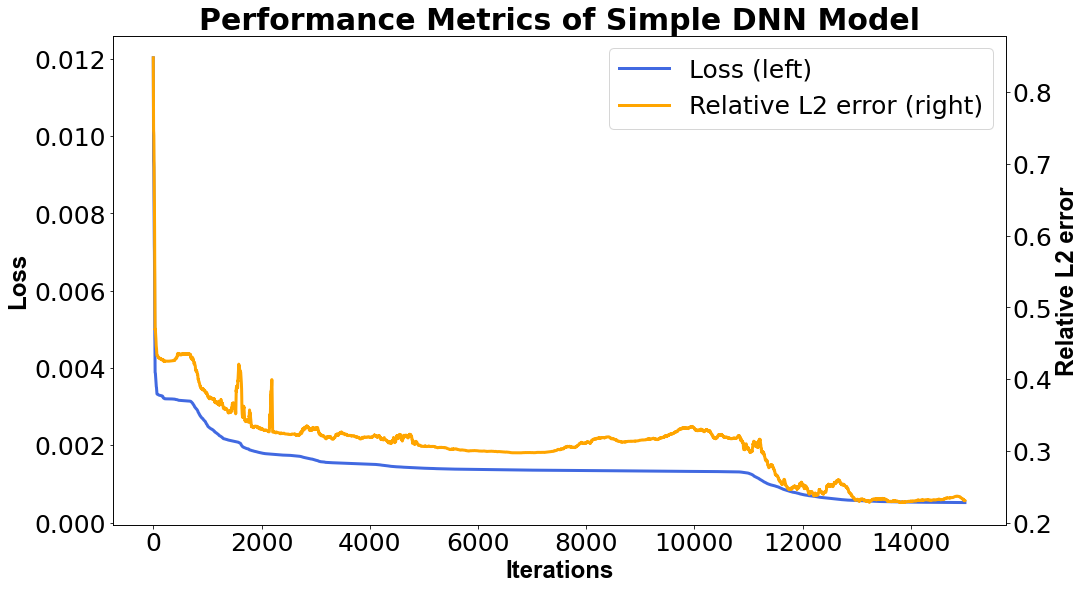

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.020427536694325597
MSE =  0.006531011366178442
RMSE =  0.08081467296338235
L2 relative error = 0.634233432166472
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

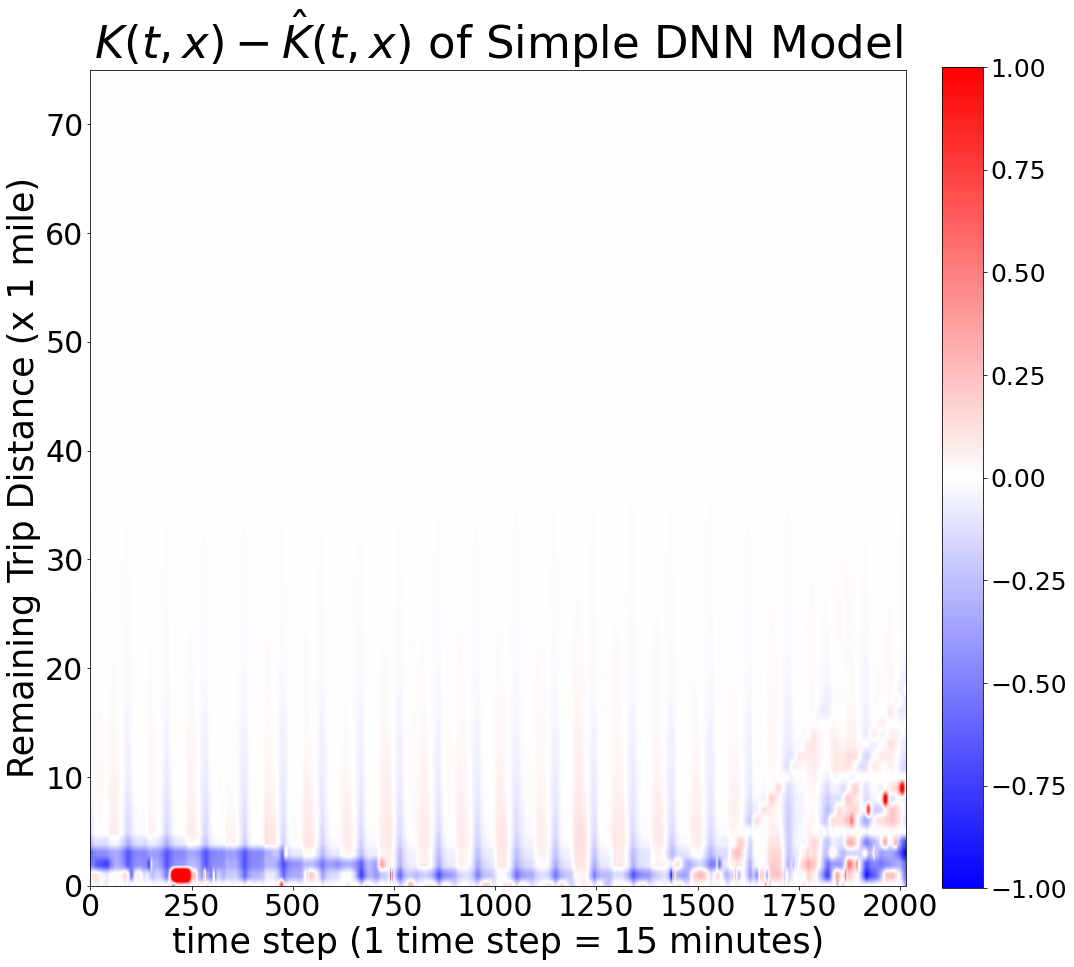

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

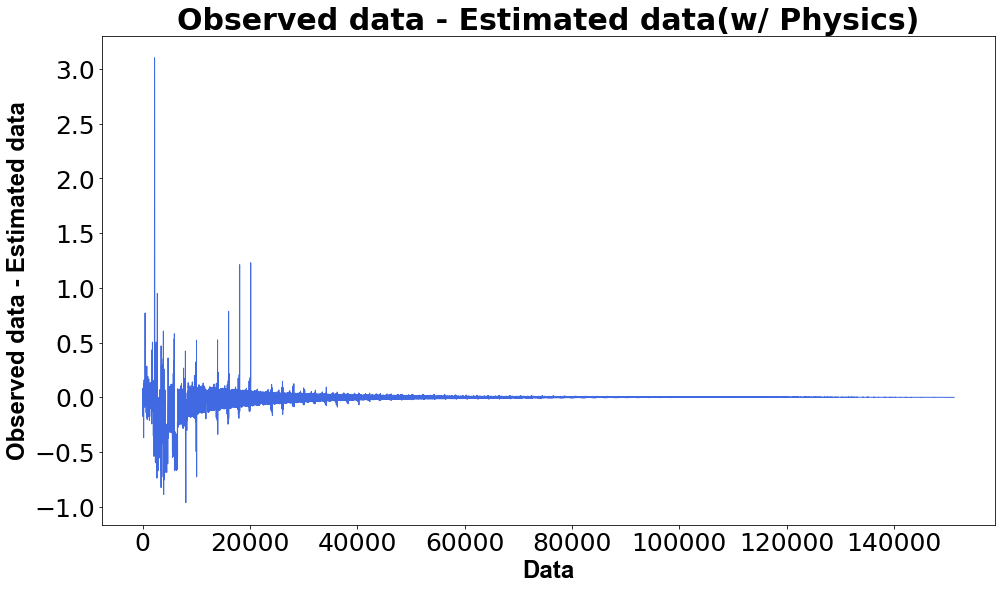

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

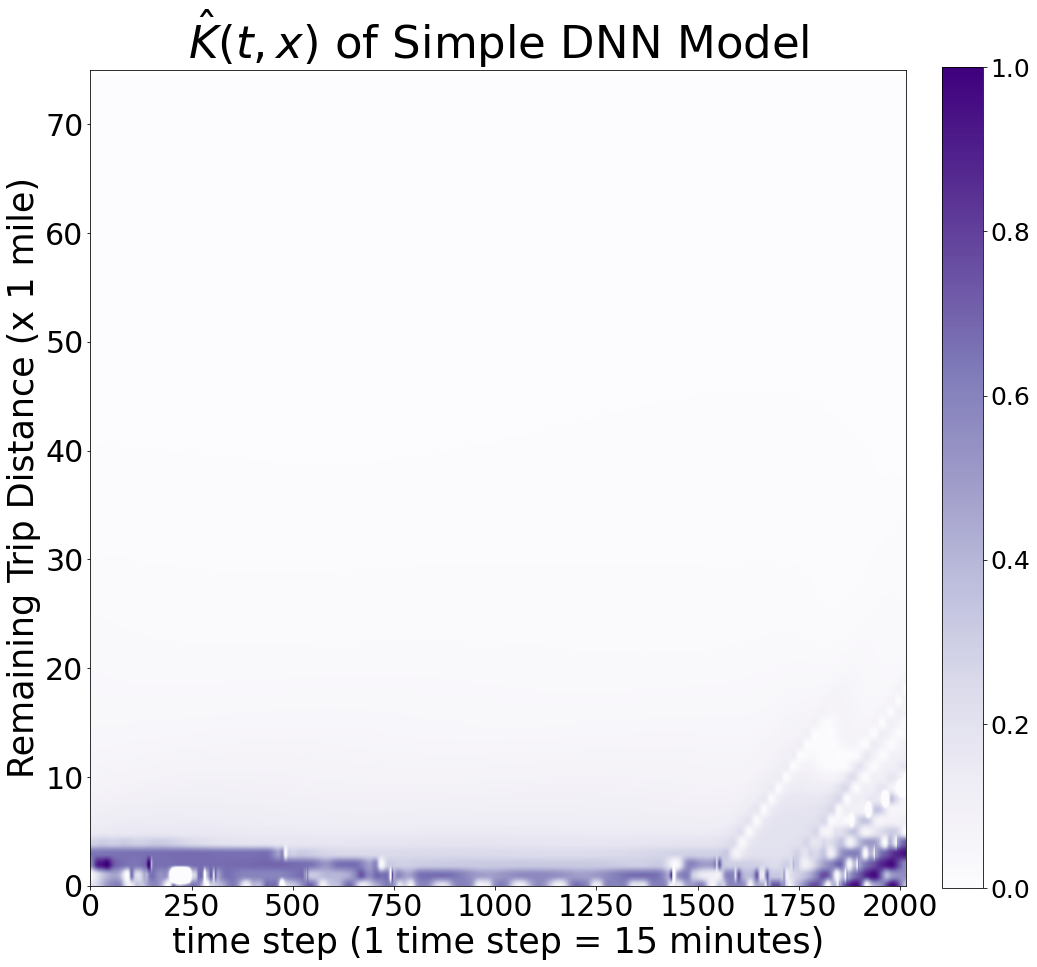

In [21]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

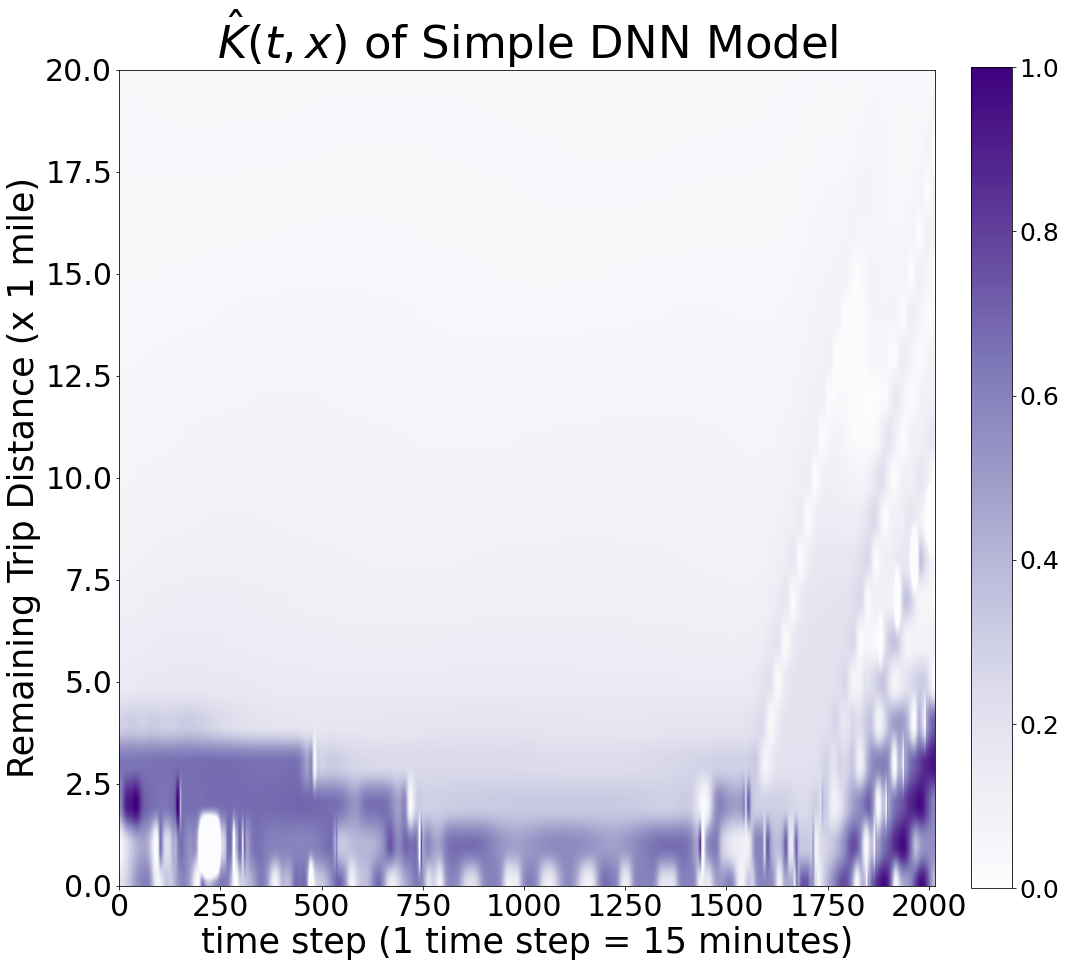

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

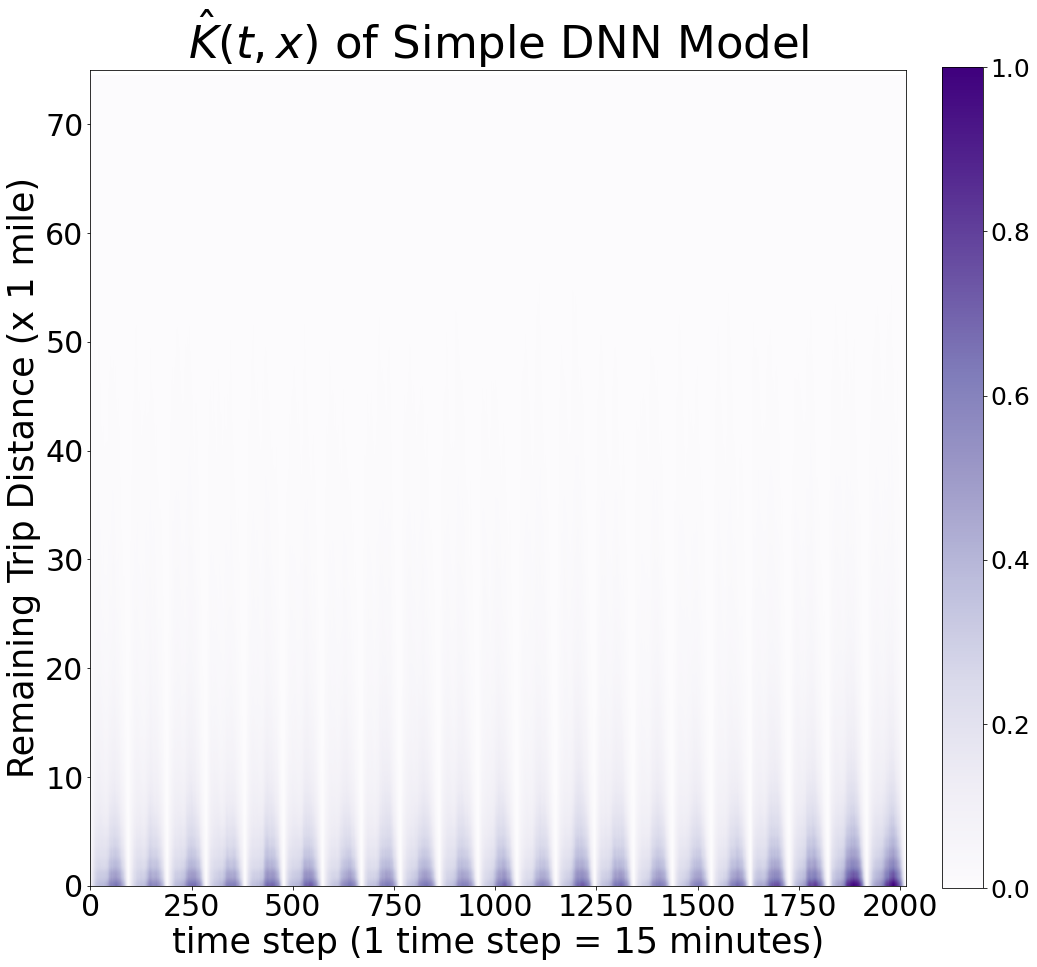

In [23]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

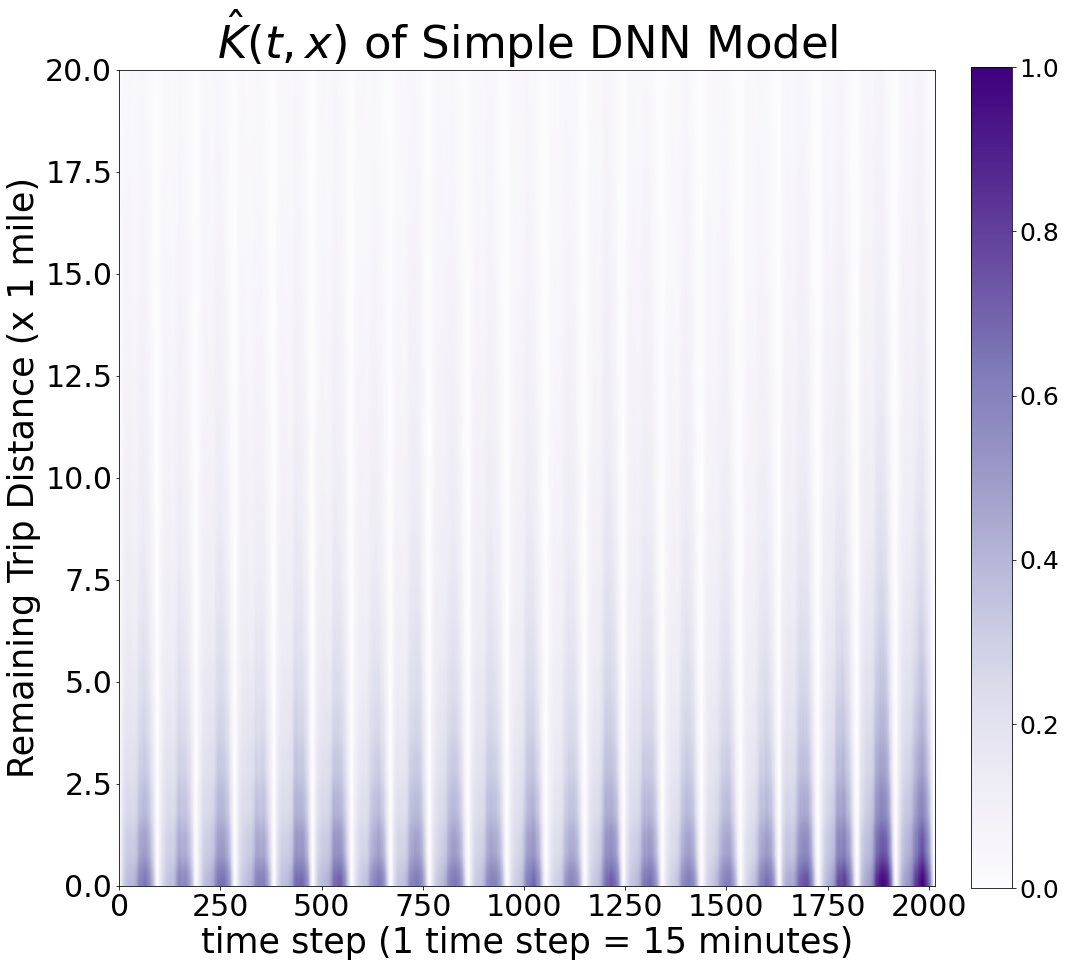

In [24]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)